In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dj.config["filepath_checksum_size_limit"] = 1000
import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from AnalysisTables.sequence_compression import CompressionIndexParams, CompressionIndexSelection, CompressionIndex
from Analysis.utils import filter_opto_data
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

CompressionIndexParams()
# SortedSpikesDecodingV1()
# (CompressionIndexParams() & {"compression_index_params_name":"slow_graph_distance"}).delete()

[2025-07-28 10:31:40,904][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-07-28 10:31:41,030][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[10:32:37][INFO] Spyglass: Initializing UserEnvironment for spikesorting: sambray_spyglass2025_04


*compression_i filter_speed   min_running_sp pf_bin_size    pf_peak_ratio  delay_range    delay_smoothin min_coincident graph_distance delay_distance smoothing_sigm
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0720slow_graph 10.0           100            5.0            10.0           1500           1000           30             1              2000           250.0         
0720v2_slow_gr 10.0           100            5.0            10.0           1500           300            30             1              2000           10000.0       
0720v3_permiss 10.0           100            5.0            1.0            1500           1000           30             0              2000           500.0         
0720v3_slow    10.0           100            5.0            10.0           1500           1000           30             0              2000           500.0         
0720v3_slow_gr 10.0           100            5.0            10.0           1500           1000           30             1              2000           500.0         
0720v4_permiss 10.0           100            5.0            1.0            1500           1000           30             0              2000           50000.0       
cross_method_g 10.0           100            5.0            1.0            1000           10             30             1              80             nan           
default        10.0           100            5.0            10.0           100            33             30             0              80             nan           
default_graph_ 10.0           100            5.0            10.0           100            33             30             1              80             nan           
fast           10.0           100            5.0            10.0           150            33             30             0              100            nan           
fast_graph_dis 10.0           100            5.0            10.0           150            33             30             1              100            nan           
permissive_def 10.0           100            5.0            1.0            100            33             30             0              80             nan           
   ...
 (Total: 15)

In [2]:
exclude_simultaneous = False
track = "early_wtrack"
track = "lineartrack"
dlc_pos = track != "lineartrack"

results = {}


from Style.style_guide import animal_style

animal_list = animal_style.index.values
animal_list = [
    x
    for x in animal_list
    if x not in ["control", "transfected", "Banner", "Odins", "Dan"]
]
animal_list.extend(["control", "transfected"])

# animal_list = ["Yoshi", "Winnie"]
# animal_list = ["transfected", "control"]

In [3]:
min_spikes_fast = 10
min_spikes_slow = 100

# min_spikes_slow = 10
# min_spikes_fast = 10

results = {}

for animal in animal_list:
    if animal in results:
        continue
    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "track_type": track,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    dataset = filter_opto_data(dataset_key)

    query = CompressionIndex() & dataset.proj(decoding_interval="interval_list_name")
    # slow_query = query & "compression_index_params_name LIKE 'permissive_slow%'"
    fast_query = query & "compression_index_params_name LIKE 'permissive_default%'"
    slow_query = query & "compression_index_params_name LIKE '0720v4_permissive_slow%'"
    # fast_query = query & "compression_index_params_name LIKE 'default%'"

    query = query - "sorted_spikes_group_name LIKE '%full_day%'"
    # query = query & "encoding_interval LIKE '%valid times'"
    control_slow_query = slow_query & "encoding_interval LIKE '%control_interval'"
    test_slow_query = slow_query & "encoding_interval LIKE '%test_interval'"
    control_fast_query = fast_query & "encoding_interval LIKE '%control_interval'"
    test_fast_query = fast_query & "encoding_interval LIKE '%test_interval'"

    control_slow_df = control_slow_query.fetch_delays_dataframes()
    test_slow_df = test_slow_query.fetch_delays_dataframes()
    control_fast_df = control_fast_query.fetch_delays_dataframes()
    test_fast_df = test_fast_query.fetch_delays_dataframes()
    # raise ValueError()
    if any(
        [
            len(df) == 0
            for df in [control_fast_df, control_slow_df, test_fast_df, test_slow_df]
        ]
    ):
        # raise ValueError("empty array")
        continue

    control_slow_df = control_slow_df[control_slow_df.n_coincidients >= min_spikes_slow]
    test_slow_df = test_slow_df[test_slow_df.n_coincidients >= min_spikes_slow]
    control_fast_df = control_fast_df[control_fast_df.n_coincidients >= min_spikes_fast]
    test_fast_df = test_fast_df[test_fast_df.n_coincidients >= min_spikes_fast]

    merged_control_df = pd.merge(
        control_slow_df,
        control_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    merged_test_df = pd.merge(
        test_slow_df,
        test_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    results_i = {
        "control": merged_control_df,
        "test": merged_test_df,
    }

    results[animal] = results_i

datasets: 2


[2025-07-28 10:33:27,970][WARNING]: Skipped checksum for file with hash: 2575ac1b-d09f-c67c-c304-fbad4116539a, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_PTQVUCD589.nwb
[2025-07-28 10:33:27,979][WARNING]: Skipped checksum for file with hash: 2575ac1b-d09f-c67c-c304-fbad4116539a, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_PTQVUCD589.nwb
[2025-07-28 10:33:27,994][WARNING]: Skipped checksum for file with hash: 8e20d5ec-d9c0-0734-8375-97ca12c32687, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_FKG7PUYVD4.nwb
[2025-07-28 10:33:28,004][WARNING]: Skipped checksum for file with hash: 8e20d5ec-d9c0-0734-8375-97ca12c32687, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_FKG7PUYVD4.nwb
[2025-07-28 10:33:28,019][WARNING]: Skipped checksum for file with hash: c7e88916-4dde-d65d-b6a8-a1c5ee06a4fe, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_9ZZ3H3WZTN.nwb
[2025-07-28 10:33:28,029][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-07-28 10:35:19,138][WARNING]: Skipped checksum for file with hash: 91db21ee-23a9-1abb-c8ba-cc71a0971cc6, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_UOY84SG6WF.nwb
[2025-07-28 10:35:19,147][WARNING]: Skipped checksum for file with hash: 91db21ee-23a9-1abb-c8ba-cc71a0971cc6, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_UOY84SG6WF.nwb
[2025-07-28 10:35:19,157][WARNING]: Skipped checksum for file with hash: 6361bfcb-367b-d7ed-6884-b244a03e0843, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_27FOB6JZVN.nwb
[2025-07-28 10:35:19,167][WARNING]: Skipped checksum for file with hash: 6361bfcb-367b-d7ed-6884-b244a03e0843, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_27FOB6JZVN.nwb
[2025-07-28 10:35:19,181][WARNING]: Skipped checksum for file with hash: 655d6bc4-840b-efe6-7db5-58d84d4b2ad1, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_11A7U7FFSC.nwb
[2025-07-28 10:35:19,190][WARNING]: Skipped checksum for file with hash: 65

datasets: 2


[2025-07-28 10:38:04,179][WARNING]: Skipped checksum for file with hash: f86bc3ad-7bff-5d14-3b34-8f3304e35e6d, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_4X306DISPL.nwb
[2025-07-28 10:38:04,191][WARNING]: Skipped checksum for file with hash: f86bc3ad-7bff-5d14-3b34-8f3304e35e6d, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_4X306DISPL.nwb
[2025-07-28 10:38:04,207][WARNING]: Skipped checksum for file with hash: 237d56ba-9442-19f8-8a99-737aa2ab5520, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_KQQ0HYQZKF.nwb
[2025-07-28 10:38:04,218][WARNING]: Skipped checksum for file with hash: 237d56ba-9442-19f8-8a99-737aa2ab5520, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_KQQ0HYQZKF.nwb
[2025-07-28 10:38:21,049][WARNING]: Skipped checksum for file with hash: c27cf53c-b04d-8805-34c5-cff48714f41e, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_H6F0JFTXGU.nwb
[2025-07-28 10:38:21,059][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-07-28 10:39:06,247][WARNING]: Skipped checksum for file with hash: 6bd1bd3c-7176-ce3d-72f0-a9493929beee, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_OEZUI96MKX.nwb
[2025-07-28 10:39:06,254][WARNING]: Skipped checksum for file with hash: 6bd1bd3c-7176-ce3d-72f0-a9493929beee, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_OEZUI96MKX.nwb
[2025-07-28 10:39:06,265][WARNING]: Skipped checksum for file with hash: 3ce31c3e-34ec-a692-1da8-1366fad8ebc4, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_WG6L2D41PO.nwb
[2025-07-28 10:39:06,272][WARNING]: Skipped checksum for file with hash: 3ce31c3e-34ec-a692-1da8-1366fad8ebc4, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_WG6L2D41PO.nwb
[2025-07-28 10:39:22,323][WARNING]: Skipped checksum for file with hash: dbb58063-ace4-67a4-8b2d-2f8cbf9e5be8, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_FTDCRB2OLM.nwb
[2025-07-28 10:39:22,330][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-07-28 10:40:07,962][WARNING]: Skipped checksum for file with hash: b15a2619-abcb-3e0b-1dae-f449be31449f, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_Y2AGNHH4JO.nwb
[2025-07-28 10:40:07,970][WARNING]: Skipped checksum for file with hash: b15a2619-abcb-3e0b-1dae-f449be31449f, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_Y2AGNHH4JO.nwb
[2025-07-28 10:40:07,984][WARNING]: Skipped checksum for file with hash: c4f631b5-f7bb-e4f6-3941-eb5685561fc6, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_M2495V0B6R.nwb
[2025-07-28 10:40:07,994][WARNING]: Skipped checksum for file with hash: c4f631b5-f7bb-e4f6-3941-eb5685561fc6, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_M2495V0B6R.nwb
[2025-07-28 10:40:22,714][WARNING]: Skipped checksum for file with hash: f075c5dc-1a6b-76ff-a624-56a0166f60eb, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_68D246U0PQ.nwb
[2025-07-28 10:40:22,723][WARNING]: Skipped checksum for file with hash: f0

datasets: 2


[2025-07-28 10:41:07,952][WARNING]: Skipped checksum for file with hash: 75b90193-c00b-fb7b-0435-b4fc9130ae96, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_Q2OXX4GLBA.nwb
[2025-07-28 10:41:07,961][WARNING]: Skipped checksum for file with hash: 75b90193-c00b-fb7b-0435-b4fc9130ae96, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_Q2OXX4GLBA.nwb
[2025-07-28 10:41:07,973][WARNING]: Skipped checksum for file with hash: bba196e1-3a61-bc40-e344-52679fd31ee8, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_QRZPRPMBXW.nwb
[2025-07-28 10:41:07,982][WARNING]: Skipped checksum for file with hash: bba196e1-3a61-bc40-e344-52679fd31ee8, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_QRZPRPMBXW.nwb
[2025-07-28 10:41:24,012][WARNING]: Skipped checksum for file with hash: fea308f8-61da-3315-4e42-2de0c7569dc9, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_5NPGR9WUUI.nwb
[2025-07-28 10:41:24,023][WARNING]: Skipped checksum for file with hash: fe

datasets: 1


[2025-07-28 10:42:08,145][WARNING]: Skipped checksum for file with hash: 883dab8c-353a-7293-c9e4-014d20a65eda, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_KTKZK1BZ13.nwb
[2025-07-28 10:42:08,152][WARNING]: Skipped checksum for file with hash: 883dab8c-353a-7293-c9e4-014d20a65eda, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_KTKZK1BZ13.nwb
[2025-07-28 10:42:22,777][WARNING]: Skipped checksum for file with hash: 9b1ee065-5cc3-05dc-413a-b128310467df, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_WNXQ9M2Z2N.nwb
[2025-07-28 10:42:22,788][WARNING]: Skipped checksum for file with hash: 9b1ee065-5cc3-05dc-413a-b128310467df, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_WNXQ9M2Z2N.nwb
[2025-07-28 10:42:36,862][WARNING]: Skipped checksum for file with hash: 89fb3e52-f9c6-e80b-1280-2585f338705a, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_0G0YVHKS5O.nwb
[2025-07-28 10:42:36,866][WARNING]: Skipped checksum for file with hash: 89

datasets: 7


[2025-07-28 10:43:12,057][WARNING]: Skipped checksum for file with hash: 883dab8c-353a-7293-c9e4-014d20a65eda, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_KTKZK1BZ13.nwb
[2025-07-28 10:43:12,065][WARNING]: Skipped checksum for file with hash: 883dab8c-353a-7293-c9e4-014d20a65eda, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_KTKZK1BZ13.nwb
[2025-07-28 10:43:12,075][WARNING]: Skipped checksum for file with hash: b15a2619-abcb-3e0b-1dae-f449be31449f, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_Y2AGNHH4JO.nwb
[2025-07-28 10:43:12,083][WARNING]: Skipped checksum for file with hash: b15a2619-abcb-3e0b-1dae-f449be31449f, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_Y2AGNHH4JO.nwb
[2025-07-28 10:43:12,093][WARNING]: Skipped checksum for file with hash: c4f631b5-f7bb-e4f6-3941-eb5685561fc6, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_M2495V0B6R.nwb
[2025-07-28 10:43:12,104][WARNING]: Skipped checksum for file with hash: c4

datasets: 11


[2025-07-28 10:43:47,686][WARNING]: Skipped checksum for file with hash: 91db21ee-23a9-1abb-c8ba-cc71a0971cc6, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_UOY84SG6WF.nwb
[2025-07-28 10:43:47,696][WARNING]: Skipped checksum for file with hash: 91db21ee-23a9-1abb-c8ba-cc71a0971cc6, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_UOY84SG6WF.nwb
[2025-07-28 10:43:47,713][WARNING]: Skipped checksum for file with hash: 6361bfcb-367b-d7ed-6884-b244a03e0843, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_27FOB6JZVN.nwb
[2025-07-28 10:43:47,728][WARNING]: Skipped checksum for file with hash: 6361bfcb-367b-d7ed-6884-b244a03e0843, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_27FOB6JZVN.nwb
[2025-07-28 10:43:47,744][WARNING]: Skipped checksum for file with hash: 655d6bc4-840b-efe6-7db5-58d84d4b2ad1, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_11A7U7FFSC.nwb
[2025-07-28 10:43:47,759][WARNING]: Skipped checksum for file with hash: 65

In [8]:
min_spikes_fast

10

In [5]:
slow_query
# animal

*nwb_file_name *unit_filter_p *sorted_spikes *position_grou *decoding_para *encoding_inte *decoding_inte *estimate_deco *compression_i analysis_file_ place_field_ob delays_object_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
Frodo20230810_ default_exclus 12_lineartrack pos 11 valid t ms_lineartrack pos 11 valid t pos 11 valid t 0              0720v3_slow    Frodo20230810_ d1262924-322d- 36d2457b-6bbc-
Frodo20230810_ default_exclus 12_lineartrack pos 11 valid t ms_lineartrack pos 11 valid t pos 11 valid t 0              0720v3_slow    Frodo20230810_ 3381e34d-ac69- 12ec7229-83dc-
Frodo20230811_ default_exclus 04_lineartrack pos 3 valid ti ms_lineartrack pos 3 valid ti pos 3 valid ti 0              0720v3_slow    Frodo20230811_ 01d71f9b-9f48- 6fc1d15b-8f25-
Frodo20230811_ default_exclus 04_lineartrack pos 3 valid ti ms_lineartrack pos 3 valid ti pos 3 valid ti 0              0720v3_slow    Frodo20230811_ dcc7f7b1-cf30- 0c8a3886-f9eb-
Frodo20230811_ default_exclus manual_full_da pos 3 valid ti ms_lineartrack pos 3 valid ti pos 3 valid ti 0              0720v3_slow    Frodo20230811_ 50fda7ff-80b9- edd8222b-9f23-
Frodo20230811_ default_exclus manual_full_da pos 3 valid ti ms_lineartrack pos 3 valid ti pos 3 valid ti 0              0720v3_slow    Frodo20230811_ f425cce5-b06f- e7242746-883a-
 (Total: 6)

## Bootstrapped heatmap spectrums

In [7]:
from Analysis.lfp_analysis import power_spectrum

slow_bin_size = 8
fast_bin_size = 3
n_boot = 1000


def get_power_spectrum_from_pairs(slow_val, fast_val, bx, by):
    # standardize order
    ind = np.where(slow_val < 0)[0]
    slow_val[ind] = -slow_val[ind]
    fast_val[ind] = -fast_val[ind]
    # get heatmap
    H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
    H = H + 1  # laplace shift
    H = H / H.sum(axis=1)[:, None]

    p_all = []
    for xx in H.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / np.mean(np.diff(bx)))
        p_all.append(p)

    return f, np.mean(p_all, axis=0)


spectrum_results = {animal: {} for animal in results}

for animal in results.keys():
    # animal = "control"
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]

    lim_x = 501

    bx = np.arange(0, lim_x, slow_bin_size)
    by = np.arange(-80, 80, fast_bin_size)

    for merged_df, cond in zip(
        [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        fast_val = merged_df.peak_delay_fast.values.copy()
        spectrums = []
        for _ in range(n_boot):
            ind_sample = np.random.choice(len(slow_val), len(slow_val), replace=True)
            f, p = get_power_spectrum_from_pairs(
                slow_val[ind_sample], fast_val[ind_sample], bx, by
            )
            spectrums.append(p)
        spectrums = np.array(spectrums)
        spectrum_results[animal][cond] = spectrums

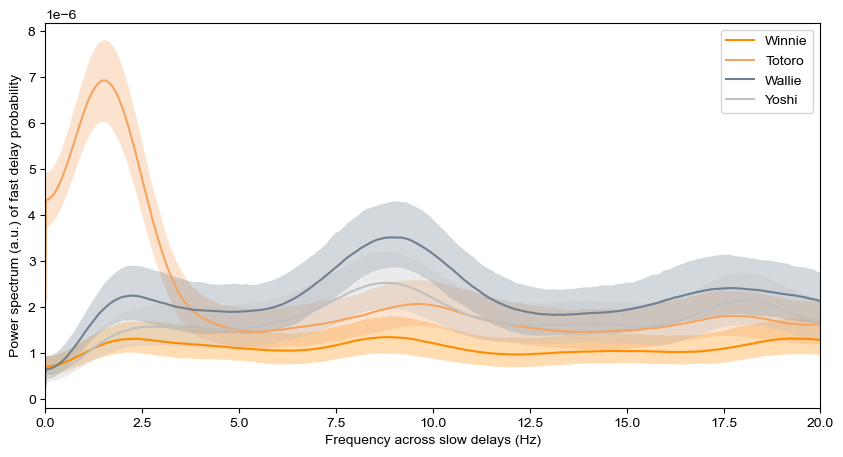

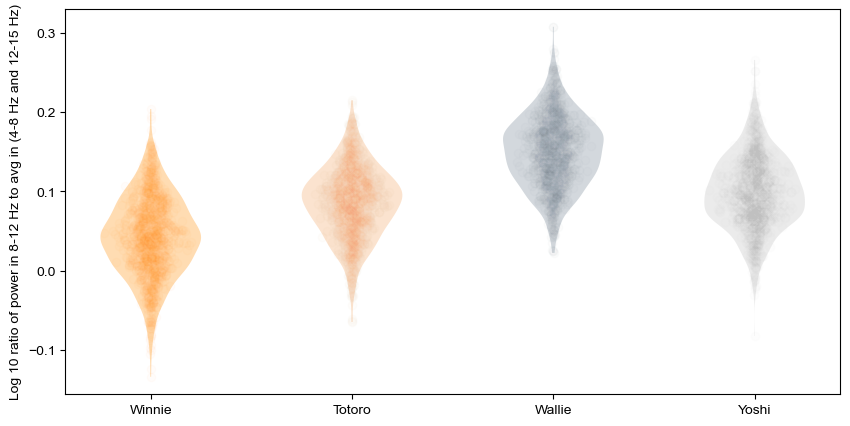

In [ ]:
cond = "stim off"
plot_list = [
    "Winnie",
    # "Frodo",
    "Totoro",
    # "Olive",
    # "Bilbo",
    "Wallie",
    "Yoshi",
    # "control",
    # "transfected",
]
log = True


fig = plt.figure(figsize=(10, 5))
for animal in plot_list:
    spectrums = spectrum_results[animal][cond]
    color = animal_style.loc[animal, "color"]

    plt.plot(f, np.median(spectrums, axis=0), color=color, label=animal)
    plt.fill_between(
        f,
        np.percentile(spectrums, 2.5, axis=0),
        np.percentile(spectrums, 97.5, axis=0),
        alpha=0.3,
        facecolor=color,
    )

plt.legend()
plt.xlim(0, 20)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")
from Analysis.utils import violin_scatter


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    if log:
        return np.log10(pos_power / neg_power)
    return pos_power / neg_power


fig2 = plt.figure(figsize=(10, 5))
all_scores = {}
for i, animal in enumerate(plot_list):
    spectrums = spectrum_results[animal][cond]
    scores = [spectrum_score(f, p) for p in spectrums]
    all_scores[animal] = scores
    violin_scatter(scores, pos=[i], color=animal_style.loc[animal, "color"])

plt.xticks(np.arange(len(plot_list)), plot_list)
if log:
    plt.ylabel("Log 10 ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")
else:
    plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

tag = "_grouped_animals"
tag = "_individual_animals"
plt.rcParams["svg.fonttype"] = "none"
fig.savefig(f"lineartrack_peak_delays_spectrograms{tag}.svg")
fig2.savefig(f"lineartrack_peak_delays_scores{tag}.svg")

# from scipy.stats import ttest_ind
# ttest_ind(all_scores['control'],all_scores['transfected'], equal_var=False).pvalue

In [ ]:
plt.rcParams["font.family"] = "arial"
import matplotlib

matplotlib.matplotlib_fname()

'/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

In [63]:
from statsmodels.formula.api import mixedlm

model_df = []

for i, (animal, data) in enumerate(all_scores.items()):
    for d in data:
        model_df.append(
            {
                "Animal": i,
                "Treatment": (
                    "transfected"
                    if animal_style.loc[animal, "background"] == "indianred"
                    else "control"
                ),
                "Score": d,
            }
        )

model_df = pd.DataFrame(model_df)
model_df
# Convert the 'Treatment' column to a categorical variable
model_df["Treatment"] = model_df["Treatment"].astype("category")
# model_df["Interval"] = model_df["Interval"].astype("category")
# model_df['Animal'] = model_df['Treatment'].astype('category')

# Fit the mixed-effects model
model = mixedlm("Score ~ Treatment", model_df, groups=model_df["Animal"])
result = model.fit()

# Print the summary of the model
print(result.summary())
result.pvalues

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Score    
No. Observations:     4000        Method:                 REML     
No. Groups:           4           Scale:                  0.0023   
Min. group size:      1000        Log-Likelihood:         6418.3526
Max. group size:      1000        Converged:              Yes      
Mean group size:      1000.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.116    0.022  5.168 0.000  0.072  0.160
Treatment[T.transfected] -0.062    0.032 -1.958 0.050 -0.124  0.000
Group Var                 0.001    0.021                           



/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept                   2.366462e-07
Treatment[T.transfected]    5.018519e-02
Group Var                   3.191039e-01
dtype: float64

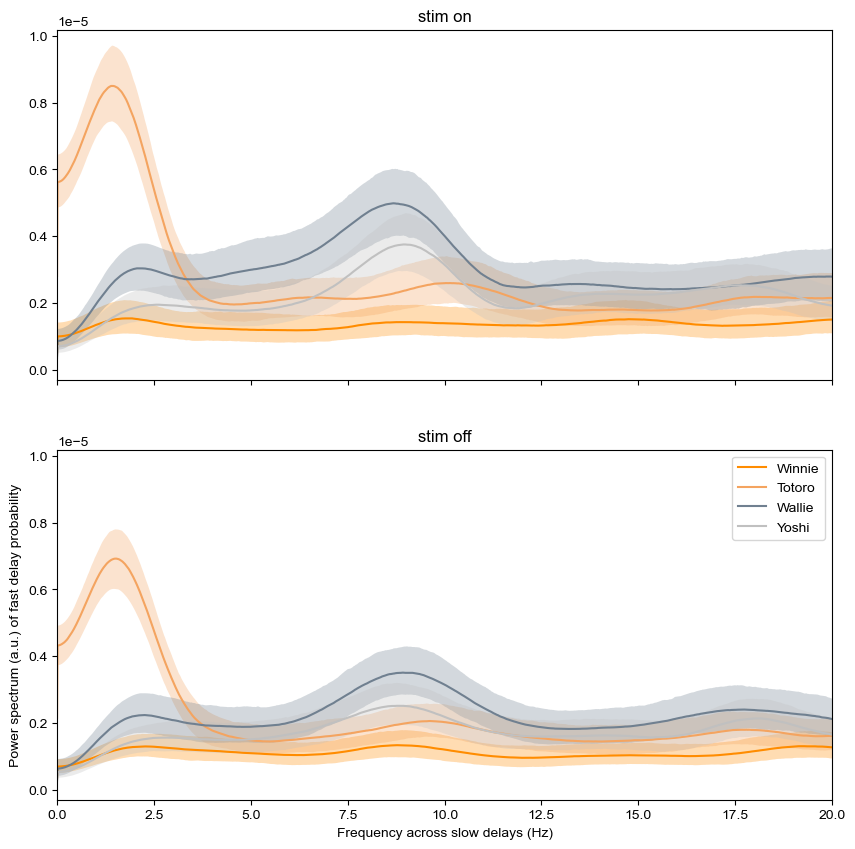

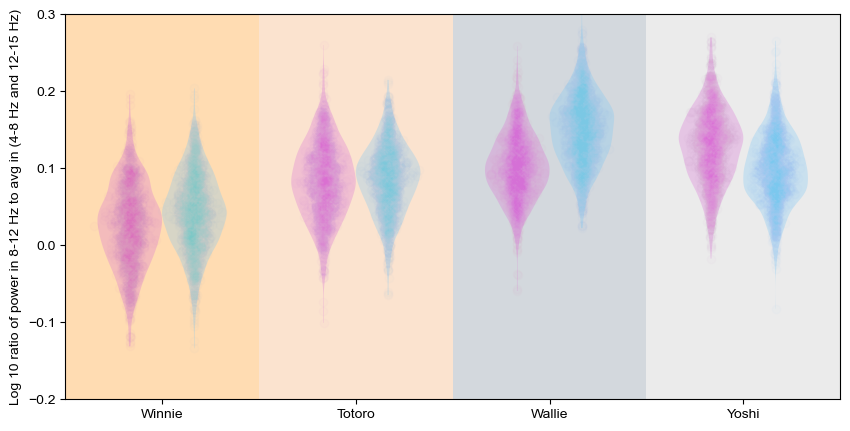

In [ ]:
from Style.style_guide import interval_style

plot_list = [
    "Winnie",
    # "Frodo",
    "Totoro",
    # "Olive",
    # "Bilbo",
    "Wallie",
    "Yoshi",
    # "control",
    # "transfected",
]
log = True


fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, sharey=True)
for animal in plot_list:
    for i, cond in enumerate(["stim on", "stim off"]):

        spectrums = spectrum_results[animal][cond]
        color = animal_style.loc[animal, "color"]
        back_color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )

        ax[i].plot(f, np.median(spectrums, axis=0), color=color, label=animal)
        ax[i].fill_between(
            f,
            np.percentile(spectrums, 2.5, axis=0),
            np.percentile(spectrums, 97.5, axis=0),
            alpha=0.3,
            facecolor=color,
        )
        ax[i].set_title(cond)
        # ax[i].patch.set_facecolor(back_color, alpha=.1)

plt.legend()
plt.xlim(0, 20)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")
from Analysis.utils import violin_scatter


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    if log:
        return np.log10(pos_power / neg_power)
    return pos_power / neg_power


fig2 = plt.figure(figsize=(10, 5))
all_scores = {}
for i, animal in enumerate(plot_list):
    for j, cond in enumerate(["stim on", "stim off"]):

        spectrums = spectrum_results[animal][cond]
        back_color = animal_style.loc[animal, "color"]
        color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )
        scores = [spectrum_score(f, p) for p in spectrums]
        all_scores[animal] = scores
        violin_scatter(scores, pos=[1.5 * i + 0.5 * j], color=color)
    plt.fill_between(
        [
            1.5 * i - 0.5,
            1.5 * (i + 1) - 0.5,
        ],
        -0.2,
        0.3,
        facecolor=back_color,
        alpha=0.3,
        zorder=-1,
    )
plt.xlim(-0.5, (len(plot_list)) * 1.5 - 0.5)
plt.ylim(-0.2, 0.3)
plt.xticks(1.5 * np.arange(len(plot_list)) + 0.25, plot_list)
if log:
    plt.ylabel("Log 10 ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")
else:
    plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

tag = "_grouped_animals"
tag = "_individual_animals"
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(f"lineartrack_peak_delays_spectrograms{tag}.svg")
# fig2.savefig(f"lineartrack_peak_delays_scores{tag}.svg")

# from scipy.stats import ttest_ind
# ttest_ind(all_scores['control'],all_scores['transfected'], equal_var=False).pvalue

In [35]:
track
dataset_key

{'animal': 'transfected',
 'targeted_phase': 90,
 'track_type': 'lineartrack',
 'min_pulse_length': 20,
 'laser_power': 77}

## Bootstrapped heatmap ridge

In [44]:
from Analysis.lfp_analysis import power_spectrum

slow_bin_size = 2
fast_bin_size = 3
n_boot = 300


def get_ridge_spectrum_from_pairs(slow_val, fast_val, bx, by):
    # standardize order
    ind = np.where(slow_val < 0)[0]
    slow_val[ind] = -slow_val[ind]
    fast_val[ind] = -fast_val[ind]
    # get heatmap
    H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
    H = H + 1  # laplace shift
    H = H / H.sum(axis=1)[:, None]

    ridge = by[np.argmax(H, axis=1)]

    f, p, _ = power_spectrum(ridge, ridge.size, 1000 / np.mean(np.diff(bx)))

    return ridge, f, p


spectrum_results = {animal: {} for animal in results}
ridge_results = {animal: {} for animal in results}

for animal in results.keys():
    # animal = "control"
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]

    lim_x = 1001

    bx = np.arange(0, lim_x, slow_bin_size)
    by = np.arange(-80, 80, fast_bin_size)

    for merged_df, cond in zip(
        [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        fast_val = merged_df.peak_delay_fast.values.copy()
        ridges = []
        spectrums = []
        for _ in range(n_boot):
            ind_sample = np.random.choice(len(slow_val), len(slow_val), replace=True)
            r, f, p = get_ridge_spectrum_from_pairs(
                slow_val[ind_sample], fast_val[ind_sample], bx, by
            )
            spectrums.append(p)
            ridges.append(r)
        spectrums = np.array(spectrums)
        ridges = np.array(ridges)
        ridge_results[animal][cond] = ridges
        spectrum_results[animal][cond] = spectrums

Text(0.5, 0, 'frequency in long timescale (Hz)')

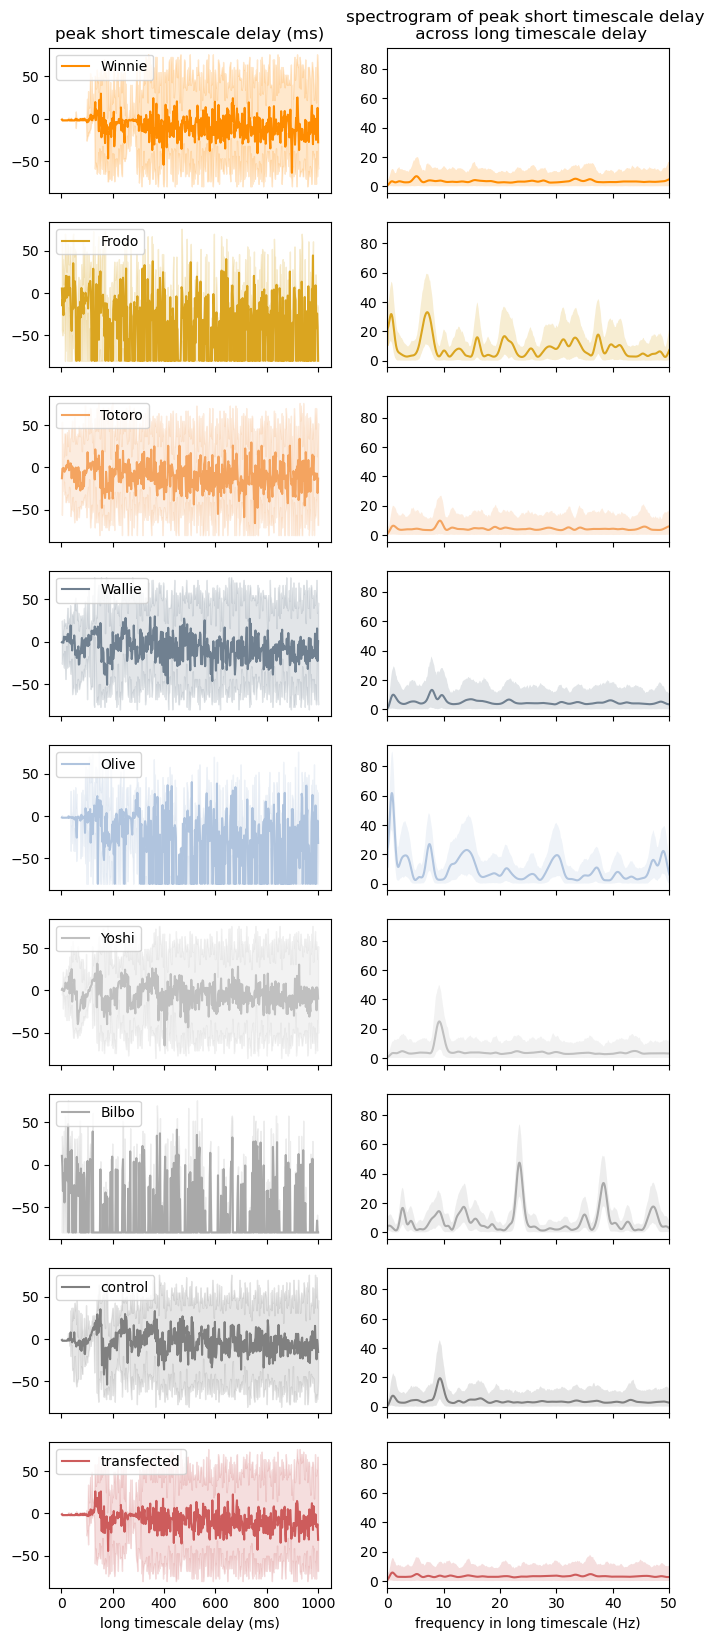

In [226]:
cond = "stim on"
fig, ax_all = plt.subplots(
    nrows=len(ridge_results), ncols=2, sharex="col", sharey="col", figsize=(8, 20)
)
ax = ax_all[:, 0]
for i, (animal, r) in enumerate(ridge_results.items()):
    ridges = r[cond]
    ax[i].plot(
        bx[1:],
        np.mean(ridges, axis=0),
        color=animal_style.loc[animal, "color"],
        label=animal,
    )
    ax[i].fill_between(
        bx[1:],
        np.percentile(ridges, 0.5, axis=0),
        np.percentile(ridges, 99.5, axis=0),
        color=animal_style.loc[animal, "color"],
        alpha=0.2,
    )
    ax[i].legend(loc="upper left")

# ax[0].set_xlim(0, 400)
ax[0].set_title("peak short timescale delay (ms)")
ax[-1].set_xlabel("long timescale delay (ms)")


# fig2, ax2 = plt.subplots(
#     nrows=len(ridge_results), sharex=True, sharey=True, figsize=(8, 20)
# )
ax2 = ax_all[:, 1]
for i, (animal, spec) in enumerate(spectrum_results.items()):
    spectrums = spec[cond]
    ax2[i].plot(
        f,
        np.mean(spectrums, axis=0),
        color=animal_style.loc[animal, "color"],
        label=animal,
    )
    ax2[i].fill_between(
        f,
        np.percentile(spectrums, 2.5, axis=0),
        np.percentile(spectrums, 97.5, axis=0),
        facecolor=animal_style.loc[animal, "color"],
        alpha=0.2,
    )

# ax2[0].set_ylim(0,15)
ax2[0].set_xlim(0, 50)
ax2[0].set_title(
    "spectrogram of peak short timescale delay \n across long timescale delay"
)
ax2[-1].set_xlabel("frequency in long timescale (Hz)")

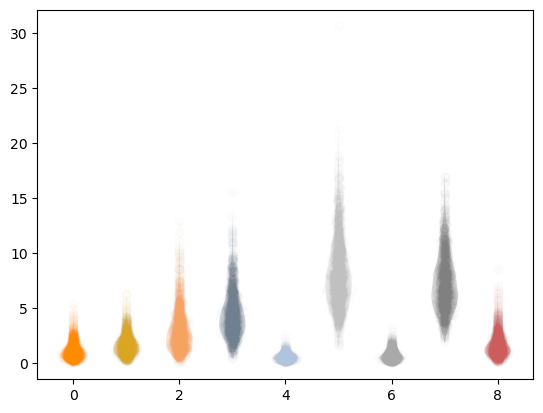

In [ ]:
fig = plt.figure()
ax = fig.gca()


def peak_spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 50), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    # return np.log(pos_power / neg_power)
    return pos_power / neg_power


for i, (animal, spec) in enumerate(spectrum_results.items()):
    spectrums = spec[cond]
    score = [peak_spectrum_score(f, s) for s in spectrums]
    # score = [f[np.argmax(s)] for s in spectrums]

    # score = np.log10(score)
    violin_scatter(
        score,
        pos=[
            i,
        ],
        color=animal_style.loc[animal, "color"],
    )

## Distribution delay peak version

In [5]:
from scipy.stats import linregress


def get_max_fast_peak_delay(row):
    fast_bins = np.arange(-200, 199) + 0.5
    ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
    peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
    return fast_bins[ind_relevant][peak_ind]

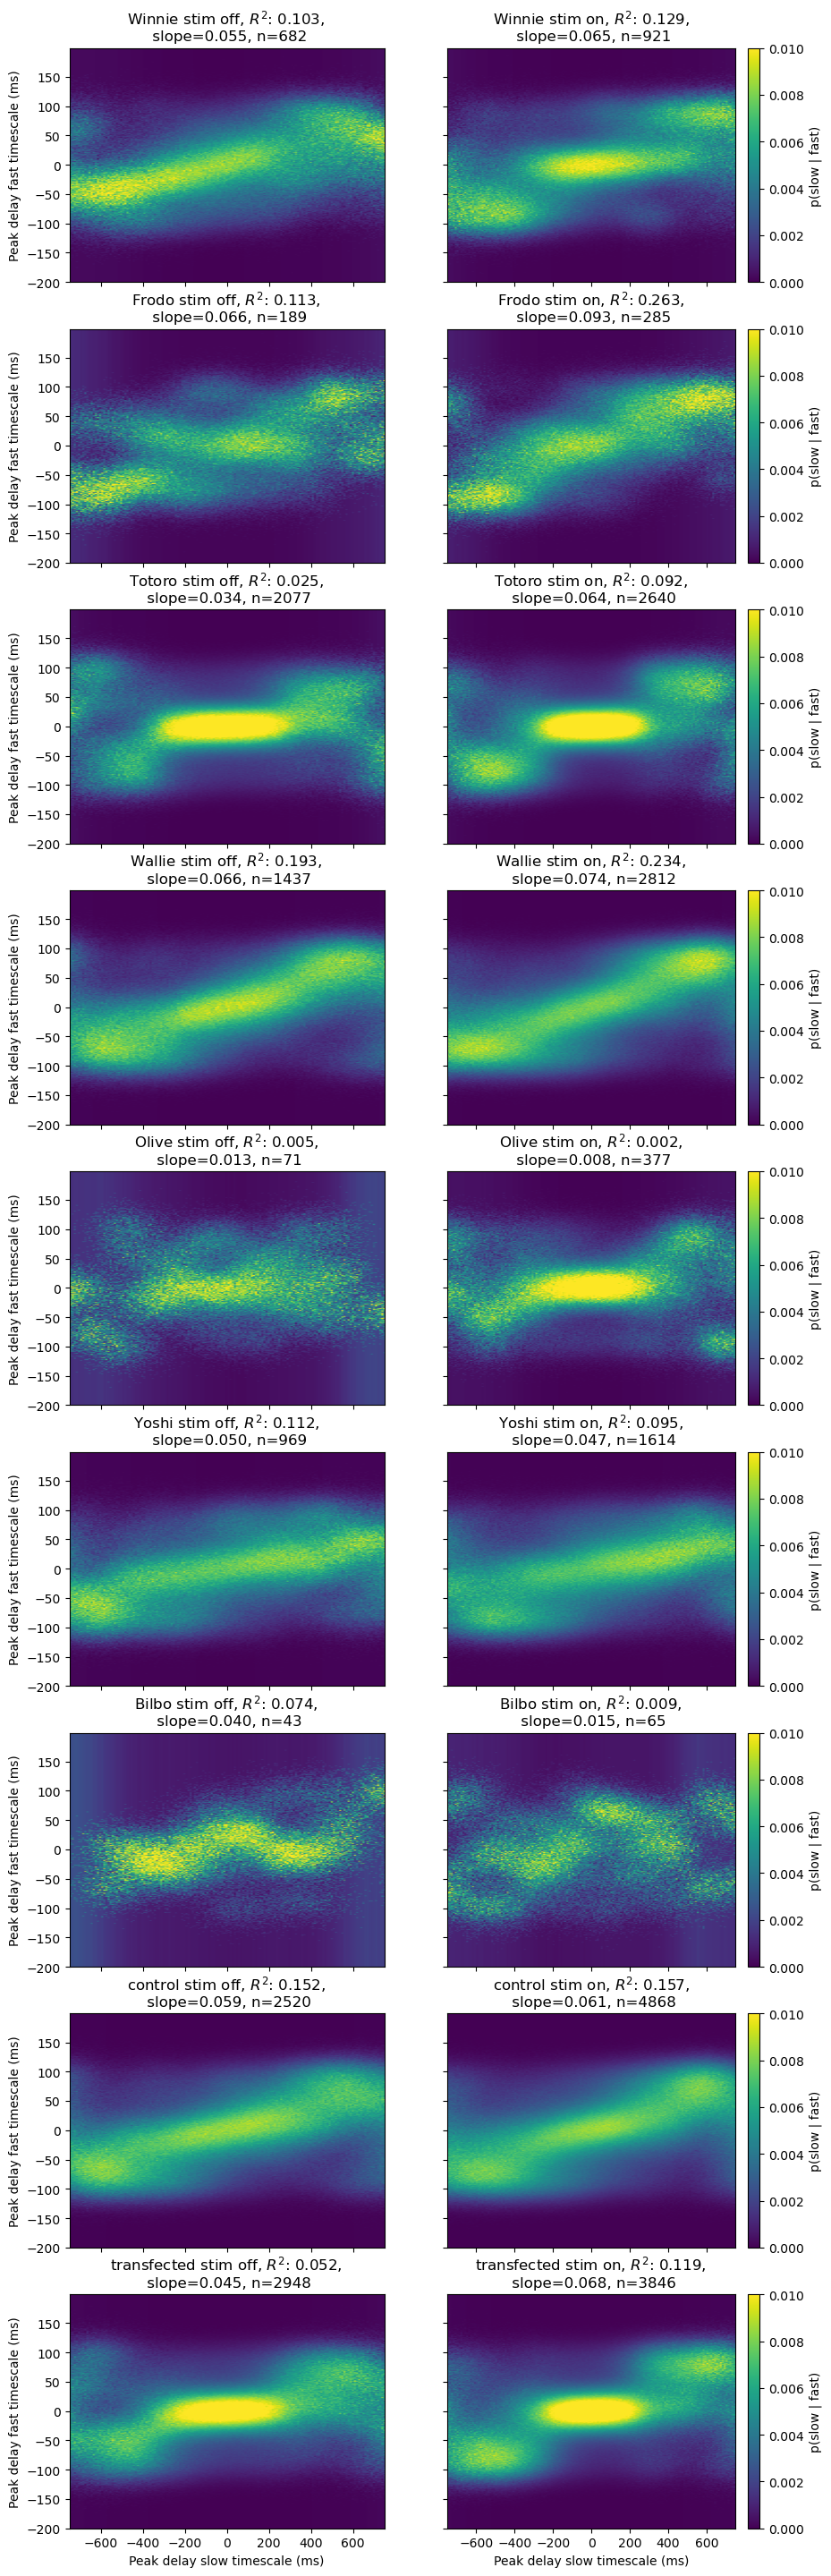

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

upsample = 3000
sigma_slow = 100
sigma_fast = 20

log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 10
fast_bin_size = 1

plot_ridge = False
long_timescale_thresh = 200

correlation_range = 750

# slow_bin_size = 16
# fast_bin_size = 6
# slow_bin_size = 2
# fast_bin_size = 1

heatmap_results = {}
fast_distribution = {}
slow_distribution = {}
counts = {}
long_timescale_counts = {}
slopes = {}
correlations = {}

fig, ax = plt.subplots(
    ncols=2,
    nrows=len(results),
    sharex=True,
    sharey=True,
    figsize=(10, 4 * len(results)),
)
for a, animal in zip(ax, results.keys()):
    heatmap_results[animal] = {}
    fast_distribution[animal] = {}
    slow_distribution[animal] = {}
    counts[animal] = {}
    long_timescale_counts[animal] = {}
    correlations[animal] = {}
    slopes[animal] = {}

    merged_control_df = results[animal]["control"].copy()
    merged_test_df = results[animal]["test"].copy()

    # merged_control_df = merged_control_df[merged_control_df.n_coincidients_fast >= 100]
    # merged_test_df = merged_test_df[merged_test_df.n_coincidients_fast >= 100]

    lim_x = correlation_range + 1
    # lim_x = 401
    # lim_x = 201
    if standardize_orders:
        bx = np.arange(0, lim_x, slow_bin_size)
    else:
        bx = np.arange(-lim_x, lim_x, slow_bin_size)

    # by = np.arange(-130, 130, fast_bin_size)
    by = np.arange(-200, 200, fast_bin_size)

    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        # fast_val = merged_df.peak_delay_fast.values.copy()
        fast_val = np.array(
            [get_max_fast_peak_delay(row) for _, row in merged_df.iterrows()]
        )

        raw_slow_val = slow_val.copy()
        raw_fast_val = fast_val.copy()
        counts[animal][cond] = len(merged_df)
        long_timescale_counts[animal][cond] = np.sum(
            np.abs(slow_val > long_timescale_thresh)
        )

        if upsample > 1:
            slow_val = [x for x in slow_val for _ in range(upsample)]
            fast_val = [x for x in fast_val for _ in range(upsample)]
            slow_val = np.array(slow_val) + np.random.normal(
                0, sigma_slow, len(slow_val)
            )
            fast_val = np.array(fast_val) + np.random.normal(
                0, sigma_fast, len(fast_val)
            )

        if standardize_orders:
            ind = np.where(slow_val < 0)[0]
            slow_val[ind] = -slow_val[ind]
            fast_val[ind] = -fast_val[ind]

        if modulo_shift:
            ind = np.where(np.abs(slow_val) < 200)[0]
            steps = np.arange(0, 500, modulo_shift)
            sub_outer = np.subtract.outer(
                slow_val,
                steps,
            )
            min_offset = np.argmin(np.abs(sub_outer), axis=1)
            slow_val = np.array(
                [sub_outer[i, min_offset[i]] for i in range(len(min_offset))]
            )
            slow_val = slow_val[ind]
            fast_val = fast_val[ind]

        dist_slow = np.histogram(slow_val, bins=bx)[0]
        dist_slow = dist_slow / dist_slow.sum()
        slow_distribution[animal][cond] = dist_slow
        dist_fast = np.histogram(fast_val, bins=by)[0]
        dist_fast = dist_fast / dist_fast.sum()
        fast_distribution[animal][cond] = dist_fast

        H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))

        H = H + 1
        # H = H / H.sum()
        H = H / H.sum(axis=1)[:, None]
        if log:
            H = np.log10(H + 1e-10)  # Log transform to visualize better
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(-2, -1),
            )
        else:
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(0, 0.01),
            )
        if plot_ridge:
            a_i.plot(bx[1:], by[np.argmax(H, axis=1)], c="cyan")
            a_i.scatter(bx[1:], by[np.argmax(H, axis=1)], c="cyan", s=10, alpha=1)

        ind_corr = np.logical_and(
            np.abs(raw_slow_val) <= correlation_range, np.abs(raw_fast_val) <= 99
        )

        corr = np.corrcoef(
            raw_slow_val[ind_corr],
            raw_fast_val[ind_corr],
        )[0, 1]
        correlations[animal][cond] = corr
        regress = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr])
        slope = regress.slope
        slopes[animal][cond] = slope

        # a_i.plot(
        #     bx, slope * bx + regress.intercept, c="cyan", linestyle="--", linewidth=1
        # )

        a_i.set_title(
            f"{animal} {cond}, $R^2$: {corr**2:.3f}, \n slope={slope:.3f}, n={counts[animal][cond]}"
        )

        heatmap_results[animal][cond] = H

# plt.colorbar(label='Counts')
for i, a_col in enumerate(ax[:, 1]):
    im = a_col.images[0] if a_col.images else None
    if im is not None:
        plt.colorbar(
            im,
            ax=a_col,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="p(slow | fast)",
        )


lim = correlation_range
if modulo_shift:
    plt.xlim(-modulo_shift // 2, modulo_shift // 2)
elif standardize_orders:
    plt.xlim(0, lim)
else:
    plt.xlim(-lim, lim)
for a in ax[-1, :]:
    # a.set_ylim(-100, 100)
    xlabel = "Peak delay slow timescale (ms)"
    if modulo_shift:
        xlabel = f"Peak delay slow timescale (ms) modulo {modulo_shift}, shifted"
    a.set_xlabel(xlabel)
for a in ax[:, 0]:
    a.set_ylabel("Peak delay fast timescale (ms)")
    # a.set_xticks(np.arange(-lim, lim + 1, 100))
    # a.set_yticks(np.arange(-80, 81, 20))
# np.corrcoef(merged_control_df.peak_delay_slow, merged_control_df.peak_delay_fast)

control stim off RMSE: 21.46
control stim on RMSE: 15.50
transfected stim off RMSE: 31.03
transfected stim on RMSE: 29.58


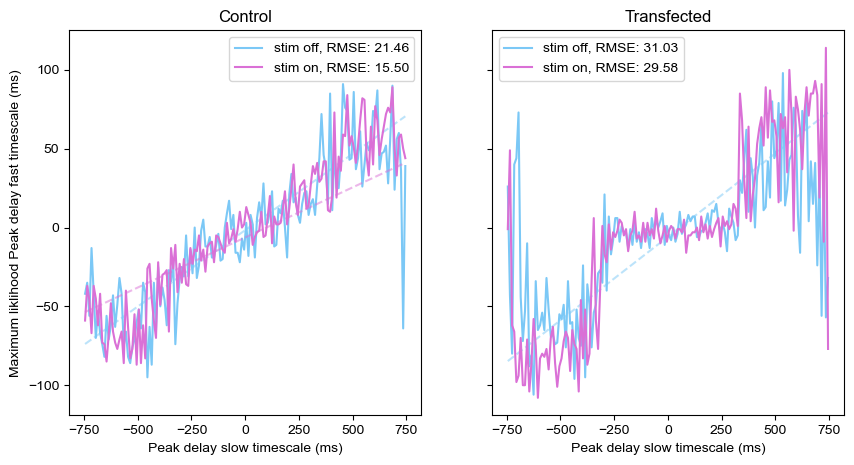

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
for animal in ["control", "transfected"]:
    for cond in ["stim off", "stim on"]:
        H = heatmap_results[animal][cond]
        bx = np.arange(-correlation_range, correlation_range + 1, slow_bin_size)
        by = np.arange(-200, 200, fast_bin_size)
        b_plot = bx[:-1] + slow_bin_size / 2  # center the bins

        ridge = by[np.argmax(H, axis=1)]
        d_ridge = np.diff(ridge)

        lin_fit = np.polyfit(b_plot, ridge, 1)
        a.plot(
            b_plot, np.polyval(lin_fit, b_plot), linestyle="--", color=color, alpha=0.5
        )
        rmse = np.sqrt(np.mean((ridge - np.polyval(lin_fit, b_plot)) ** 2))
        print(f"{animal} {cond} RMSE: {rmse:.2f}")

        a = ax[0] if animal == "control" else ax[1]
        color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )
        a.plot(b_plot, ridge, label=f"{cond}, RMSE: {rmse:.2f}", color=color)

ax[0].set_title("Control")
ax[1].set_title("Transfected")
ax[0].set_ylabel("Maximum liklihood Peak delay fast timescale (ms)")
ax[1].set_xlabel("Peak delay slow timescale (ms)")
ax[0].set_xlabel("Peak delay slow timescale (ms)")
ax[0].legend()
ax[1].legend()

In [ ]:
1 / 0.06

16.666666666666668

In [46]:
pd.DataFrame(counts)

Winnie  Frodo  Totoro  Wallie  Olive  Yoshi  Bilbo  control  \
stim off     682    189    2077    1437     71    969     43     2520   
stim on      923    285    2640    2814    377   1614     65     4870   

          transfected  
stim off         2948  
stim on          3848

In [47]:
pd.DataFrame(long_timescale_counts)

Winnie  Frodo  Totoro  Wallie  Olive  Yoshi  Bilbo  control  \
stim off     153     39     205     452     16    309     14      791   
stim on      225     65     226     851     80    485     18     1434   

          transfected  
stim off          397  
stim on           516

In [ ]:
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_peak_delay_heatmaps.svg"
)

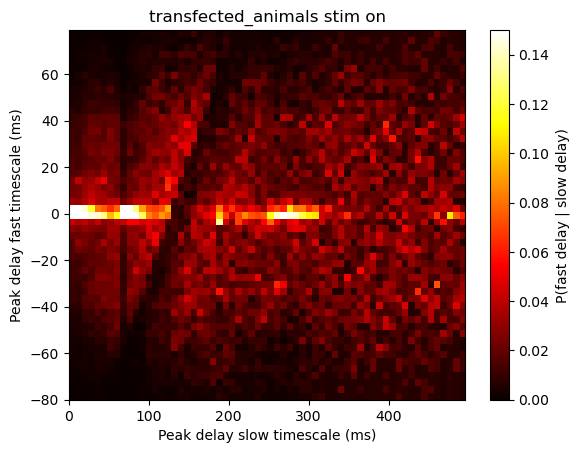

In [262]:
fig = plt.figure()
plt.imshow(
    H.T,
    origin="lower",
    extent=(bx[0], bx[-1], by[0], by[-1]),
    cmap="hot",
    aspect="auto",
    clim=(0, 0.15),
)
plt.title(f"{animal}_animals {cond}")
plt.colorbar(label="P(fast delay | slow delay)")
plt.xlabel("Peak delay slow timescale (ms)")
plt.ylabel("Peak delay fast timescale (ms)")

fig.savefig("heatmap_colorbar.svg")

# Heirarchical bootstrap RMSE

In [294]:
correlation_range = 750
n_boot = 10000
upsample = 100
sigma_slow = 100
sigma_fast = 20

log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 10
fast_bin_size = 1

bx = np.arange(-correlation_range, correlation_range + 1, slow_bin_size)
by = np.arange(-200, 200, fast_bin_size)

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

In [296]:
from tqdm import tqdm

bootstrap_results = {}
bootstrap_ridges = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    bootstrap_ridges[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            if upsample > 1:
                slow_val = [x for x in slow_val for _ in range(upsample)]
                fast_val = [x for x in fast_val for _ in range(upsample)]
                slow_val = np.array(slow_val) + np.random.normal(
                    0, sigma_slow, len(slow_val)
                )
                fast_val = np.array(fast_val) + np.random.normal(
                    0, sigma_fast, len(fast_val)
                )
            # fast_val = fast_val%100

            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < 1000,
            )

            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        ridges_ = []
        rmse_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])

            H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
            ridge = by[np.argmax(H, axis=1)]

            linfit = np.polyfit(bx[1:], ridge, 1)
            rmse = np.sqrt(np.mean((ridge - np.polyval(linfit, bx[1:])) ** 2))

            ridges_.append(ridge)
            rmse_.append(rmse)

        bootstrap_ridges[group][cond] = ridges_
        bootstrap_results[group][cond] = rmse_

Bootstrapping targeted test: 100%|██████████| 10000/10000 [16:42<00:00,  9.97it/s]


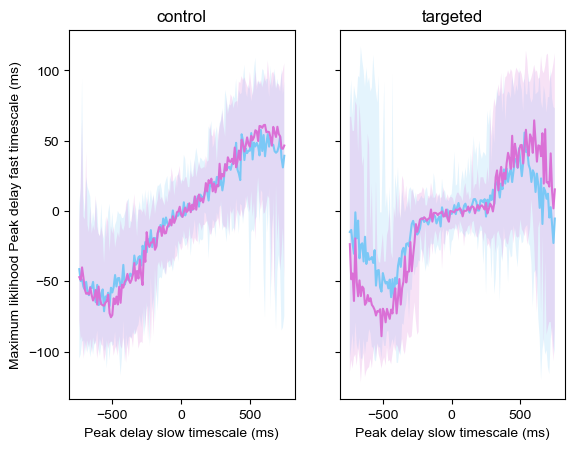

In [315]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)

for i, animal in enumerate(bootstrap_ridges):
    for cond in bootstrap_ridges[animal]:
        ridges = bootstrap_ridges[animal][cond]
        rmse = bootstrap_results[animal][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        ax[i].plot(
            bx[1:],
            np.mean(ridges, axis=0),
            label=animal,
            color=color,
        )
        ax[i].fill_between(
            bx[1:],
            np.percentile(ridges, 2.5, axis=0),
            np.percentile(ridges, 97.5, axis=0),
            facecolor=color,
            alpha=0.2,
        )
        # ax[1].plot(
        #     [animal] * len(rmse),
        #     rmse,
        #     marker="o",
        #     linestyle="",
        #     color=color,
        # )
        ax[i].set_title(f"{animal}")
        ax[i].set_xlabel("Peak delay slow timescale (ms)")

ax[0].set_ylabel("Maximum liklihood Peak delay fast timescale (ms)")
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_peak_delay_ridge_bootstraps.svg"
)

interval effect (control animals) p-value: 0.224
interval effect (targeted animals) p-value: 0.496
group effect (control interval) p-value: 0.041
group effect (test interval) p-value: 0.011


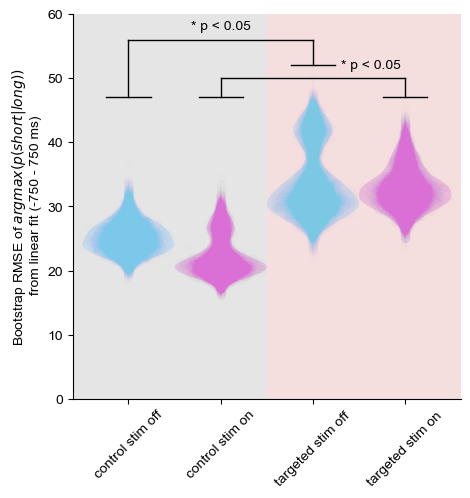

In [ ]:
ticks = []
labels = []
from Style.style_guide import interval_style
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [bootstrap_results[group]["control"], bootstrap_results[group]["test"]]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond],
        bootstrap_results["targeted"][cond],
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")


# indicate sig difference
y_max = 47
y_bridge = 50
x1 = ticks[1]
x2 = ticks[3]
bar_rng = 0.12
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.65,
    y_bridge + 2,
    "* p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
    color="k",
)

# indicate sig difference
y_max = 47, 52
y_bridge = 56
x1 = ticks[0]
x2 = ticks[2]
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
plt.text(
    (x1 + x2) / 2,
    y_bridge + 2,
    "* p < 0.05",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap RMSE of $argmax(p(short|long))$ \n from linear fit ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    500,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    500,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0, 60)

fig.gca().spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_bootstrap_RMSE_EXCLUDEanimals.svg"
)

# Heirarchical Bootstrap Correlation Coefficients (WITH OLIVE)

In [ ]:
correlation_range = 200
fast_correlation_range = 99
n_boot = 1000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

In [ ]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            # fast_val = fast_val%100

            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        c_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])
            corr = np.corrcoef(slow_val, fast_val)[0, 1]
            c_.append(corr)
        c_ = np.array(c_)
        bootstrap_results[group][cond] = c_

Bootstrapping targeted test: 100%|██████████| 1000/1000 [00:00<00:00, 1161.10it/s]


interval effect (control animals) p-value: 0.475
interval effect (targeted animals) p-value: 0.271
group effect (control interval) p-value: 0.004
group effect (test interval) p-value: 0.102


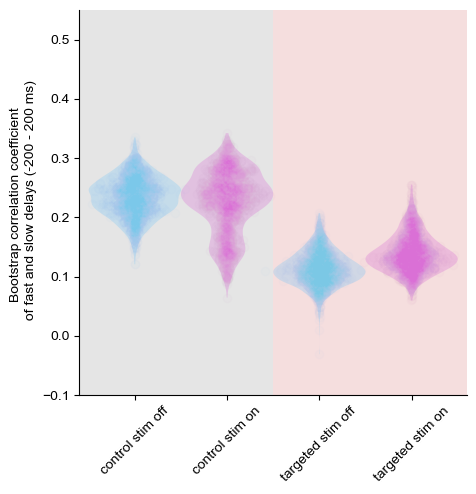

In [ ]:
ticks = []
labels = []
from Style.style_guide import interval_style
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [bootstrap_results[group]["control"], bootstrap_results[group]["test"]]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond],
        bootstrap_results["targeted"][cond],
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")


# # indicate sig difference
# y_max = 0.42
# y_bridge = 0.45
# x1 = ticks[1]
# x2 = ticks[3]
# bar_rng = 0.12
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.text(
#     x1 + (x2 - x1) * 0.65,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="left",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# # indicate sig difference
# y_max = 0.42, 0.47
# y_bridge = 0.50
# x1 = ticks[0]
# x2 = ticks[2]
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
# plt.text(
#     (x1 + x2) / 2,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap correlation coefficient \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.6,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.6,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.1, 0.55)

fig.gca().spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_bootstrap_correlation_coefficients_WITHOlive.pdf"
# )

# Old Analyses

### Ridge tracing

(0.0, 20.0)

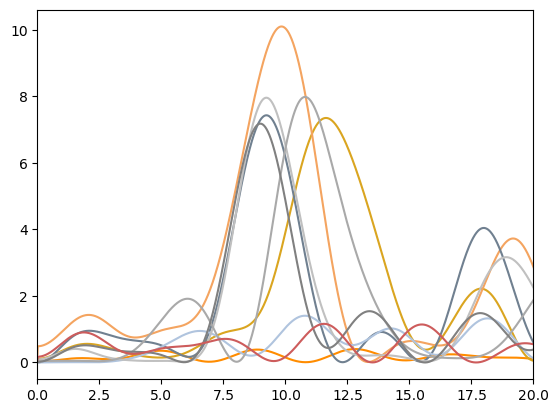

In [218]:
for animal in heatmap_results:
    H = heatmap_results[animal]["stim on"]
    ridge = np.argmax(H, axis=1)
    # plt.plot(bx[1:], ridge)

    f, p, _ = power_spectrum(ridge, ridge.size, 1000 / slow_bin_size)
    plt.plot(
        f,
        p,
        color=animal_style.loc[
            animal,
            "color",
        ],
    )


plt.xlim(0, 20)

<BarContainer object of 2 artists>

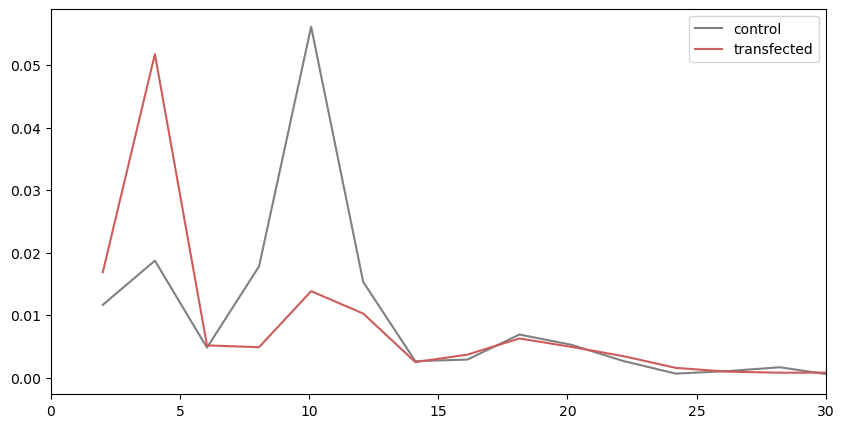

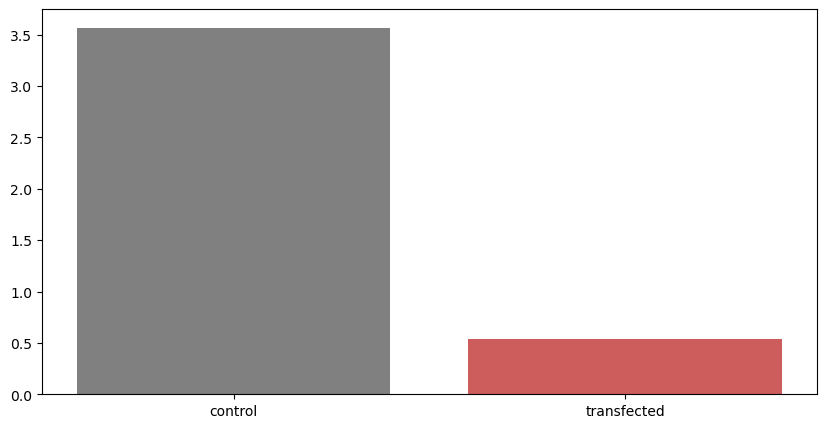

In [219]:
fig = plt.figure(figsize=(10, 5))


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    return pos_power / neg_power


scores = {}
for animal in results.keys():
    if animal not in ["transfected", "control"]:
        continue

    x = heatmap_results[animal]["stim on"]
    power_spectra = np.abs(np.fft.fft(x, axis=0)) ** 2
    freq = np.fft.fftfreq(
        x.shape[0], d=slow_bin_size / 1000
    )  # Assuming sampling rate of 1000 Hz
    f = freq
    ind = f > 0
    # f = np.log10(f)
    plt.plot(
        f[ind],
        np.mean(power_spectra, axis=1)[ind],
        color=animal_style.loc[animal].color,
        label=animal,
    )
    scores[animal] = spectrum_score(f[ind], np.mean(power_spectra, axis=1)[ind])

plt.xlim(0, 30)
plt.legend(loc=1)

fig2 = plt.figure(figsize=(10, 5))
plt.bar(
    list(scores.keys()),
    list(scores.values()),
    color=[animal_style.loc[x].color for x in scores.keys()],
)

Text(0, 0.5, 'Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)')

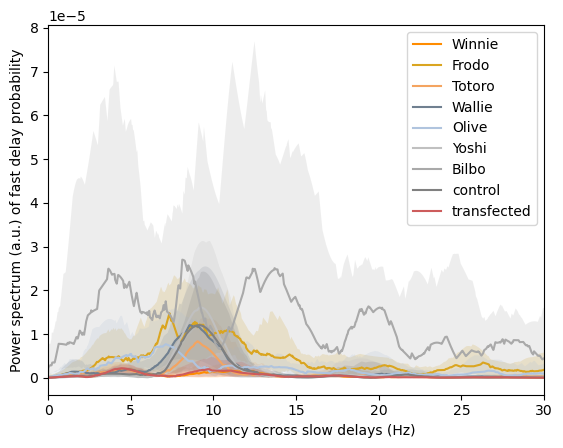

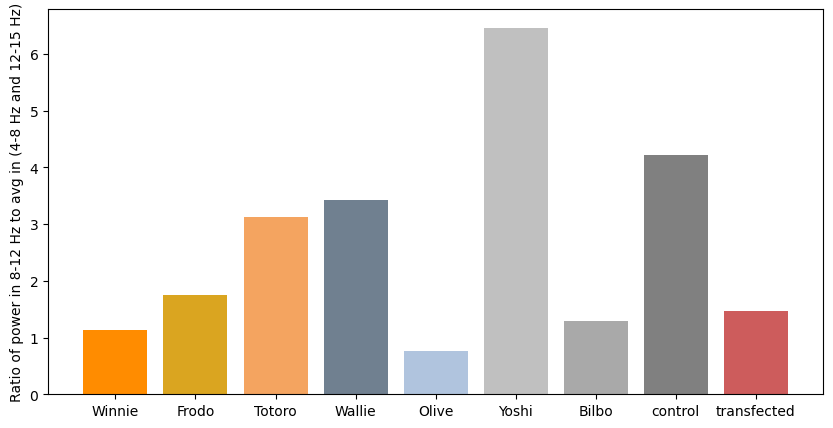

In [ ]:
from Analysis.lfp_analysis import power_spectrum

scores = {}
for animal in results.keys():
    # if animal  not in ["transfected", "control"]:
    #     continue

    x = heatmap_results[animal]["stim on"]
    p_all = []
    for xx in x.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / slow_bin_size)
        p_all.append(p)

    plt.plot(
        f, np.median(p_all, axis=0), color=animal_style.loc[animal].color, label=animal
    )
    plt.fill_between(
        f,
        np.percentile(p_all, 25, axis=0),
        np.percentile(p_all, 75, axis=0),
        facecolor=animal_style.loc[animal].color,
        alpha=0.2,
    )

    # scores[animal] = spectrum_score(f, np.mean(p_all, axis=0))
    scores[animal] = [spectrum_score(f, p) for p in p_all]

plt.xlim(0, 30)
plt.legend(loc=1)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")

fig2 = plt.figure(figsize=(10, 5))
plt.bar(
    list(scores.keys()),
    # list(scores.values()),
    [np.mean(s) for s in scores.values()],
    color=[animal_style.loc[x].color for x in scores.keys()],
)
# for i, (animal, s) in enumerate(scores.items()):
# violin_scatter(s, pos=[i], color=animal_style.loc[animal, "color"])
plt.xticks(np.arange(len(scores)), scores.keys())
plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

(0.0, 3e-05)

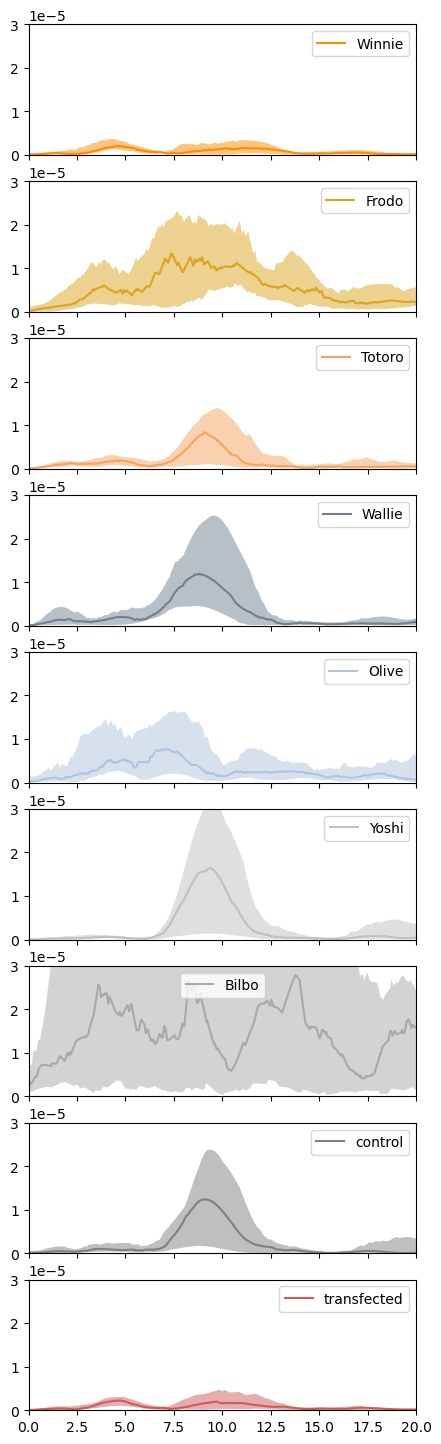

In [ ]:
fig, ax = plt.subplots(len(results), sharex=True, sharey=True, figsize=(5, 18))

from Analysis.lfp_analysis import power_spectrum

scores = {}
for i, animal in enumerate(results.keys()):
    # if animal  not in ["transfected", "control"]:
    #     continue

    x = heatmap_results[animal]["stim on"]
    p_all = []
    for xx in x.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / slow_bin_size)
        p_all.append(p)

    ax[i].plot(
        f, np.median(p_all, axis=0), color=animal_style.loc[animal].color, label=animal
    )
    std = np.std(p_all, axis=0)
    ax[i].fill_between(
        f,
        np.percentile(p_all, 25, axis=0),
        np.percentile(p_all, 75, axis=0),
        # np.mean(p_all, axis=0) - std,
        # np.mean(p_all, axis=0) + std,
        facecolor=animal_style.loc[animal].color,
        alpha=0.5,
    )
    ax[i].legend()
plt.xlim(0, 20)
plt.ylim(0, 3e-5)

In [ ]:
from scipy.signal import correlate2d

x = ref_H
autocorr = correlate2d(x, x, mode="full", boundary="symm")

In [102]:
from numpy.fft import fft2, fftshift

fft_result = fftshift(fft2(autocorr))
magnitude_spectrum = np.abs(fft_result)

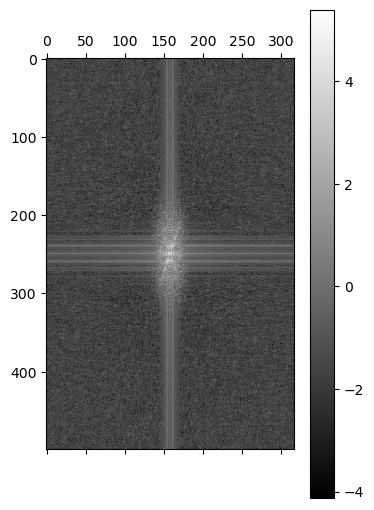

In [ ]:
plt.matshow(
    np.log10(magnitude_spectrum),
    cmap="gray",
)
plt.colorbar()

### Distribution entropy vs. slow delay

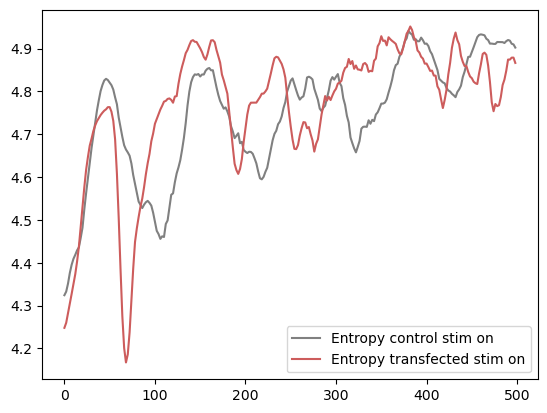

In [ ]:
from scipy.stats import entropy
from Style.style_guide import animal_style

H.shape

bx.shape, entropy(H, axis=1).shape
for animal in heatmap_results:
    if animal not in ["control", "transfected"]:
        continue

    for cond in heatmap_results[animal]:
        if cond == "stim off":
            continue
        H = heatmap_results[animal][cond]
        fast_dist = fast_distribution[animal][cond]
        slow_dist = slow_distribution[animal][cond]
        val = (entropy(H, axis=1) - entropy(fast_dist)) / entropy(fast_dist)
        val = entropy(H, axis=1)
        plt.plot(
            bx[:-1],
            val,
            label=f"Entropy {animal} {cond}",
            color=animal_style.loc[animal, "color"],
        )

plt.legend()

### KL divergence from reference

Text(0, 0.5, 'KL divergence of p(fast peak delay | slow peak delay) from control stim off')

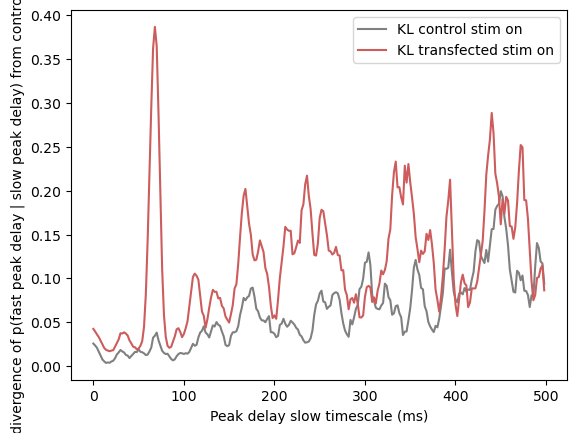

In [ ]:
sh = 0.0

ref_H = heatmap_results["control"]["stim off"].copy() + sh
# ref_H = ref_H/ ref_H.sum(axis=1)[:, None]  # Normalize reference histogram

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
for a, animal in zip(ax, results.keys()):
    # if animal in ["control", "transfected", "Olive","Bilbo","Frodo"]:
    #     continue
    if animal not in ["control", "transfected"]:
        continue

    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):
        if cond == "stim off":
            continue

        test_H = H.copy() + sh
        # test_H = test_H / test_H.sum(axis=1)[:, None]  #

        kl = np.zeros(H.shape[0])
        for i in range(H.shape[0]):
            kl[i] = np.nansum(test_H[i] * np.log(test_H[i] / ref_H[i, :]))
            # kl[i] = np.nansum(ref_H[i, :] * np.log(ref_H[i, :] / test_H[i]))
        plt.plot(
            bx[:-1],
            kl,
            label=f"KL {animal} {cond}",
            color=animal_style.loc[animal, "color"],
        )

        # plt.set_title(f"{animal} {cond}")
plt.legend()
plt.xlabel("Peak delay slow timescale (ms)")
plt.ylabel(
    "KL divergence of p(fast peak delay | slow peak delay) from control stim off"
)

In [36]:
H.shape, fast_dist.shape

((31, 26), (26,))

### Mutual information

Text(0.5, 1.0, 'Mutual Information between Slow and Fast Peak Delays')

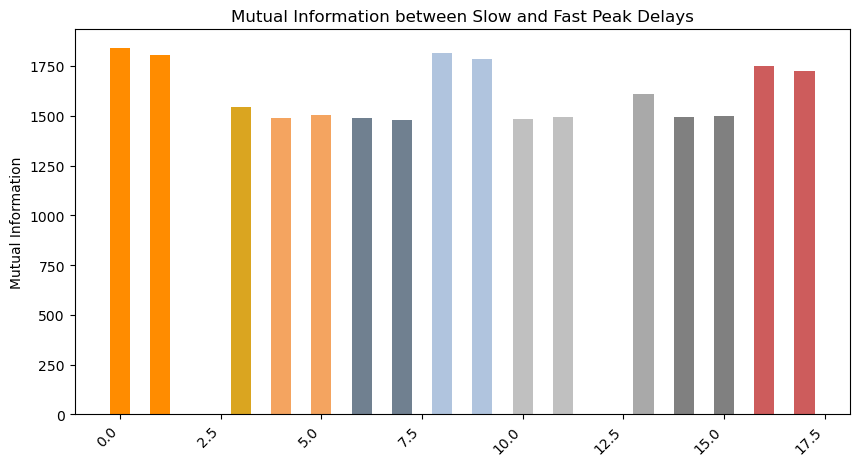

In [89]:
def discrete_mutual_information(p_xy, p_x, p_y, log_base=np.e):
    # Calculate the discrete mutual information
    mi = np.nansum(
        p_xy * np.log(p_xy / (p_x[:, None] * p_y[None, :])) / np.log(log_base)
    )
    return mi


labels = []
mi_values = []
for animal in heatmap_results:
    for cond in heatmap_results[animal]:
        H = heatmap_results[animal][cond]
        fast_dist = fast_distribution[animal][cond]
        slow_dist = slow_distribution[animal][cond]
        mi = discrete_mutual_information(H, slow_dist, fast_dist)
        # plt.plot(bx[:-1], mi * np.ones_like(bx[:-1]), label=f"MI {animal} {cond}", color=animal_style.loc[animal, "color"])
        labels.append(f"{animal} {cond}")
        mi_values.append(mi)
plt.figure(figsize=(10, 5))
plt.bar(
    np.arange(len(mi_values)),
    mi_values,
    color=[
        animal_style.loc[animal, "color"]
        for animal in heatmap_results.keys()
        for cond in heatmap_results[animal].keys()
    ],
    width=0.5,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Slow and Fast Peak Delays")

In [ ]:
for l, v in zip(labels, mi_values):
    print(f"{l}: {v:.4f}")

transfected stim off: 157.5724
transfected stim on: 152.4203
control stim off: 123.1601
control stim on: 122.6668


### Corelational difference

In [90]:
def smooth_heatmap(H, kernel_size=1):
    from scipy.ndimage import gaussian_filter

    H = H.copy()
    H += 1e-10  # Avoid division by zero
    return gaussian_filter(H, sigma=kernel_size)

[[-0.01149001 -0.18073617 -0.35761278 ... -0.19323155 -0.20971572
  -0.2915478 ]
 [-0.30445341 -0.0915595  -0.33582404 ... -0.11048742 -0.24769701
  -0.08543395]
 [-0.08764739 -0.09332452 -0.37207812 ...  0.06420688 -0.07916602
  -0.12609569]
 ...
 [ 0.70450814  0.70450814  0.70450814 ...  1.51742149  1.40347814
   1.35772065]
 [ 0.73304133  0.73304133  1.03407132 ...  1.03407132  1.73304133
   1.63613132]
 [ 0.72516555  0.72516555  0.72516555 ...  1.42413556  1.36198765
   1.02619555]]
[[-0.41787304 -0.48551637 -0.54993152 ... -0.49471307 -0.50330323
  -0.62499853]
 [-0.52648036 -0.31110811 -0.55879268 ... -0.48876875 -0.68451951
  -0.60074251]
 [-0.42351079 -0.29716429 -0.47217826 ... -0.3411595  -0.48609277
  -0.51164688]
 ...
 [ 0.21696038  0.21696038  0.51799037 ...  0.21696038  0.21696038
  -0.08406962]
 [ 0.53500655  0.23397656  0.71109781 ... -0.54417469  0.23397656
   0.23397656]
 [ 0.55978613  0.95772614  0.95772614 ...  0.4348474  -0.21836512
  -0.34330385]]
[[ 0.37980086  0

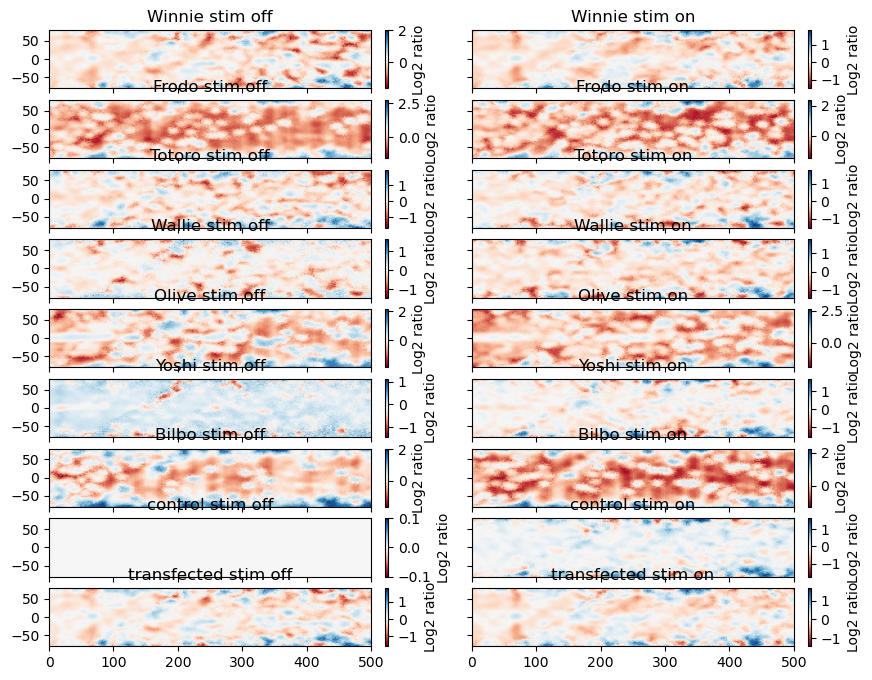

In [ ]:
kernel = 10
ref_H = heatmap_results["control"]["stim off"]

fig, ax = plt.subplots(
    nrows=len(results), ncols=2, figsize=(10, 8), sharex=True, sharey=True
)
for a, animal in zip(ax, results.keys()):
    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):

        val = smooth_heatmap(heatmap_results[animal][cond], kernel)
        ref_val = smooth_heatmap(ref_H, kernel)

        val = np.log10(heatmap_results[animal][cond] / ref_H)

        # var_val = val-val.mean()
        # var_ref = ref_val-ref_val.mean()
        # val = var_val * var_ref

        # val = np.log10(val)

        print(val)
        c_scale = 2
        a_i.imshow(
            val.T,
            cmap="RdBu",
            aspect="auto",
            origin="lower",
            extent=(bx[0], bx[-1], by[0], by[-1]),
            # clim=(-c_scale, c_scale),
        )
        # plt.colorbar(label='Log ratio of stim on to stim off')
        a_i.set_title(f"{animal} {cond}")
        fig.colorbar(
            a_i.images[-1],
            ax=a_i,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="Log2 ratio",
        )

### change in relative values

[[-0.59982812 -0.59464458 -0.58428655 ...  0.42357536  0.43259283
   0.43701998]
 [-0.59454331 -0.58939808 -0.57911853 ...  0.4209063   0.42992943
   0.43435953]
 [-0.58396668 -0.57889653 -0.5687709  ...  0.41552934  0.424561
   0.42899558]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
[[-0.86638545 -0.86124417 -0.85097721 ... -0.21190141 -0.20812437
  -0.20623364]
 [-0.85678431 -0.85173416 -0.84164808 ... -0.20737543 -0.2035663
  -0.20166049]
 [-0.83766997 -0.83279972 -0.82307066 ... -0.19842232 -0.19454601
  -0.19260842]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
[[0. 0. 0. ... 0. 0

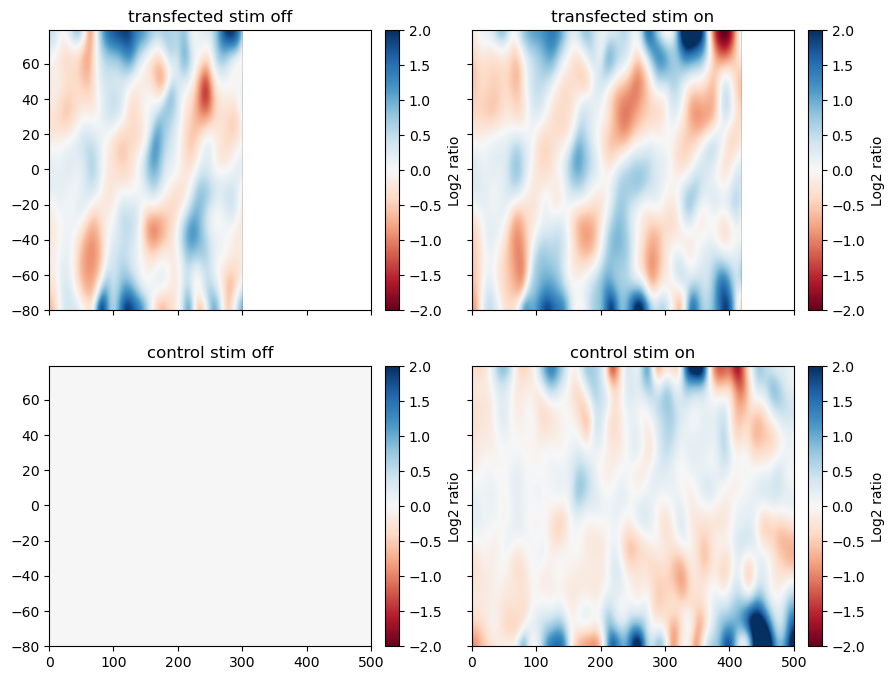

In [ ]:
kernel = 10
ref_H = heatmap_results["control"]["stim off"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
for a, animal in zip(ax, results.keys()):
    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):

        val = smooth_heatmap(heatmap_results[animal][cond], kernel)

        val = val / smooth_heatmap(ref_H, kernel)
        val = np.log2(val)
        print(val)
        c_scale = 2
        a_i.imshow(
            val.T,
            cmap="RdBu",
            aspect="auto",
            origin="lower",
            extent=(bx[0], bx[-1], by[0], by[-1]),
            clim=(-c_scale, c_scale),
        )
        # plt.colorbar(label='Log ratio of stim on to stim off')
        a_i.set_title(f"{animal} {cond}")
        fig.colorbar(
            a_i.images[-1],
            ax=a_i,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="Log2 ratio",
        )

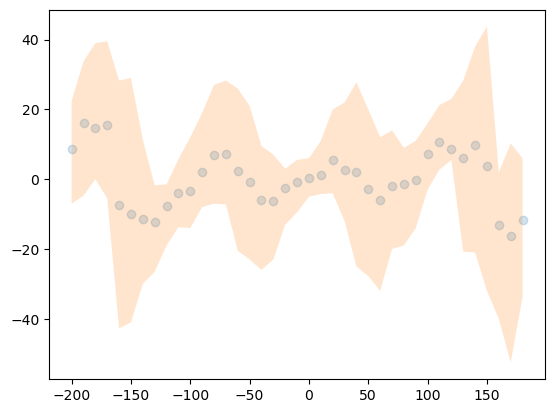

In [ ]:
import numpy as np


df = merged_test_df

fast = df.peak_delay_fast.values
slow = df.peak_delay_slow.values

bins = np.arange(-200, 200, 10)
yy = np.zeros(len(bins) - 1)
lo = np.zeros(len(bins) - 1)
hi = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    mask = (slow >= bins[i]) & (slow < bins[i + 1])
    if mask.sum() == 0:
        continue
    yy[i] = fast[mask].mean()
    lo[i] = np.percentile(fast[mask], 25)
    hi[i] = np.percentile(fast[mask], 75)

plt.scatter(bins[:-1], yy, alpha=0.2)
plt.fill_between(bins[:-1], lo, hi, alpha=0.2)

## distribution cross product version

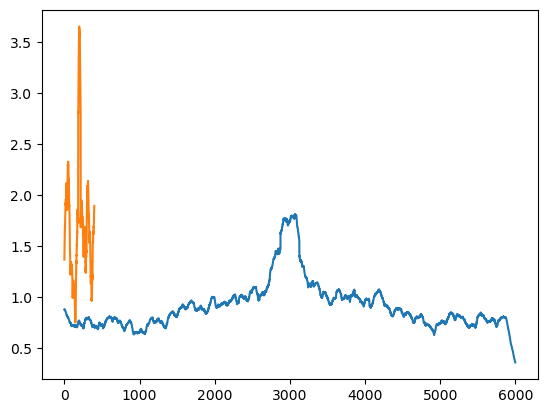

In [ ]:
results

animal = "Winnie"
control_df = results[animal]["control"]
test_df = results[animal]["test"]

merged_df = test_df

plt.plot(merged_df.cross_corr_slow.values[0])
plt.plot(merged_df.cross_corr_fast.values[0])

In [73]:
merged_df

s_id_1  \
0      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
1      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
2      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
3      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
4      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
...                                       ...   
31898  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31899  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31900  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31901  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31902  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   

                                        s_id_2  field_loc_1_slow  \
0       16e76a3a-8b9c-47e5-f989-268fd883f527_1        102.176318   
1       16e76a3a-8b9c-47e5-f989-268fd883f527_2        102.176318   
2       16e76a3a-8b9c-47e5-f989-268fd883f527_3        102.176318   
3       16e76a3a-8b9c-47e5-f989-268fd883f527_5        102.176318   
4       16e76a3a-8b9c-47e5-f989-268fd883f527_6        102.176318   
...                                        ...               ...   
31898  3fb6683e-9011-1e15-5c45-613152554557_10        102.176318   
31899  3fb6683e-9011-1e15-5c45-613152554557_13        102.176318   
31900  3fb6683e-9011-1e15-5c45-613152554557_15        102.176318   
31901   4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_4        102.176318   
31902   4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_5        102.176318   

       field_loc_2_slow  distance_slow  \
0            102.176318              0   
1            102.176318              0   
2            102.176318              0   
3            102.176318              0   
4            102.176318              0   
...                 ...            ...   
31898        102.176318              0   
31899        102.176318              0   
31900        102.176318              0   
31901        102.176318              0   
31902        102.176318              0   

                                         cross_corr_slow  peak_delay_slow  \
0      [0.8792326130801925, 0.878855088945861, 0.8784...               69   
1      [0.35764694344988546, 0.3620412505046985, 0.36...             -190   
2      [1.0485978852411952, 1.0394451910277005, 1.030...               -1   
3      [0.03513260203389736, 0.03527525603429052, 0.0...                0   
4      [0.14075418640930296, 0.1413228877156195, 0.14...              -94   
...                                                  ...              ...   
31898  [1.5102466977786693, 1.5051941516530902, 1.497...              -65   
31899  [0.3538665578247544, 0.354926033183901, 0.3559...              -66   
31900  [0.42834843424168817, 0.43518428899381045, 0.4...              -65   
31901  [0.7131608192762099, 0.7177474962407279, 0.716...               10   
31902  [0.17820145879230315, 0.1817023147751055, 0.18...                7   

       n_coincidients_slow  field_loc_1_fast  field_loc_2_fast  distance_fast  \
0                     3200        102.176318        102.176318              0   
1                     3517        102.176318        102.176318              0   
2                     2038        102.176318        102.176318              0   
3                      953        102.176318        102.176318              0   
4                     1341        102.176318        102.176318              0   
...                    ...               ...               ...            ...   
31898                 6561        102.176318        102.176318              0   
31899                 4669        102.176318        102.176318              0   
31900                 4587        102.176318        102.176318              0   
31901                 2230        102.176318        102.176318              0   
31902                 2293        102.176318        102.176318              0   

                                         cross_corr_fast  peak_delay_fast  \
0      [1.3672488743250215, 1.4246041292269063, 1.483...               -2   
1      [0.7823483214690752, 0.870655333312379, 0.9827...                4   

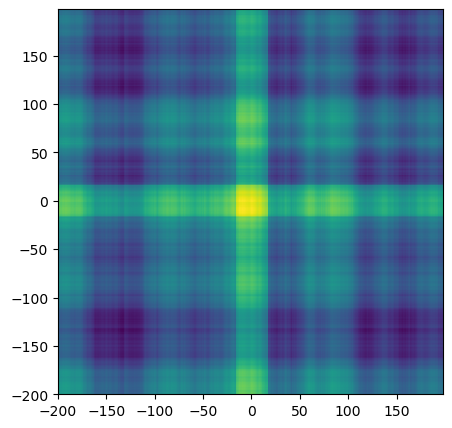

In [ ]:
intensities = []

for ii in range(len(merged_df)):
    # corr_slow = merged_df.cross_corr_slow.values[ii].copy()
    if merged_df.n_coincidients_fast[ii] < 50:
        print(f"Skipping {ii} for {animal} due to low coincidients")
        continue

    corr_slow = merged_df.cross_corr_fast.values[ii].copy()
    corr_fast = merged_df.cross_corr_fast.values[ii].copy()
    if merged_df.peak_delay_slow[ii] < 0:
        corr_slow = np.flip(corr_slow)
        corr_fast = np.flip(corr_fast)

    x_slow = np.arange(-len(corr_slow) // 2, len(corr_slow) // 2)
    x_fast = np.arange(-len(corr_fast) // 2, len(corr_fast) // 2)

    ind_slow = np.where(np.abs(x_slow) < 500)[0]
    ind_fast = np.where(np.abs(x_fast) < 500)[0]
    corr_slow = corr_slow[ind_slow]
    corr_fast = corr_fast[ind_fast]
    x_slow = x_slow[ind_slow]
    x_fast = x_fast[ind_fast]

    val = np.multiply.outer(corr_slow, corr_fast) ** 0.5
    val = val / np.mean(val)  # Normalize the cross product
    intensities.append(val)

val = np.log10(val + 1e-10)  # Log transform to visualize better
plt.figure(figsize=(10, 5))
plt.imshow(val.T, origin="lower", extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]))
intensities = np.array(intensities)

intensities = np.mean(intensities, axis=0)

Text(0.5, 1.0, 'CrossCorr(Delay 1) * CrossCorr(Delay 2) Winnie early_wtrack')

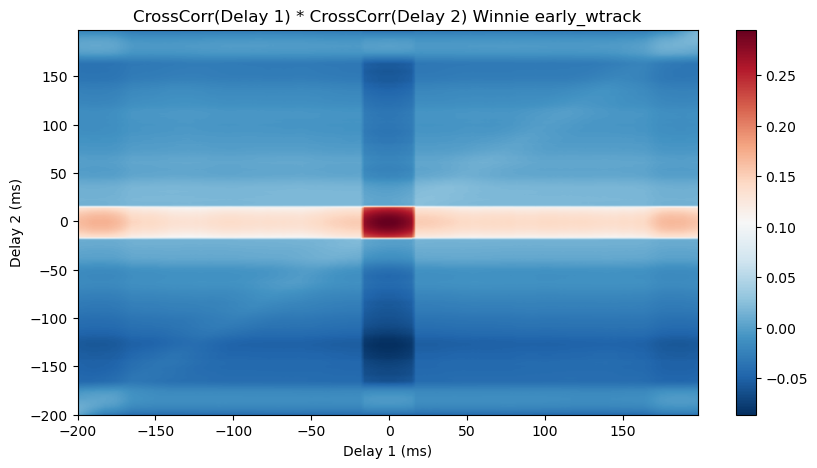

In [ ]:
fig = plt.figure(figsize=(10, 5))
val = intensities.copy()
val = val / np.mean(val, axis=0)  # Normalize the cross product
val = np.log10(val + 1e-10)  # Log transform to visualize better
plt.imshow(
    val,
    origin="lower",
    extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]),
    cmap="RdBu_r",
    aspect="auto",
)


# val = intensities
# # val = val/ np.sum(val,axis=1)[:, None]  # Normalize the cross product
# plt.imshow(
#     val.T,
#     origin="lower",
#     extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]),
#     cmap="hot",
#     aspect="auto",
# )

plt.colorbar()
plt.xlabel("Delay 1 (ms)")
plt.ylabel("Delay 2 (ms)")

plt.title(f"CrossCorr(Delay 1) * CrossCorr(Delay 2) {animal} {track}")

# Plot Examples

(-1000.0, 1000.0)

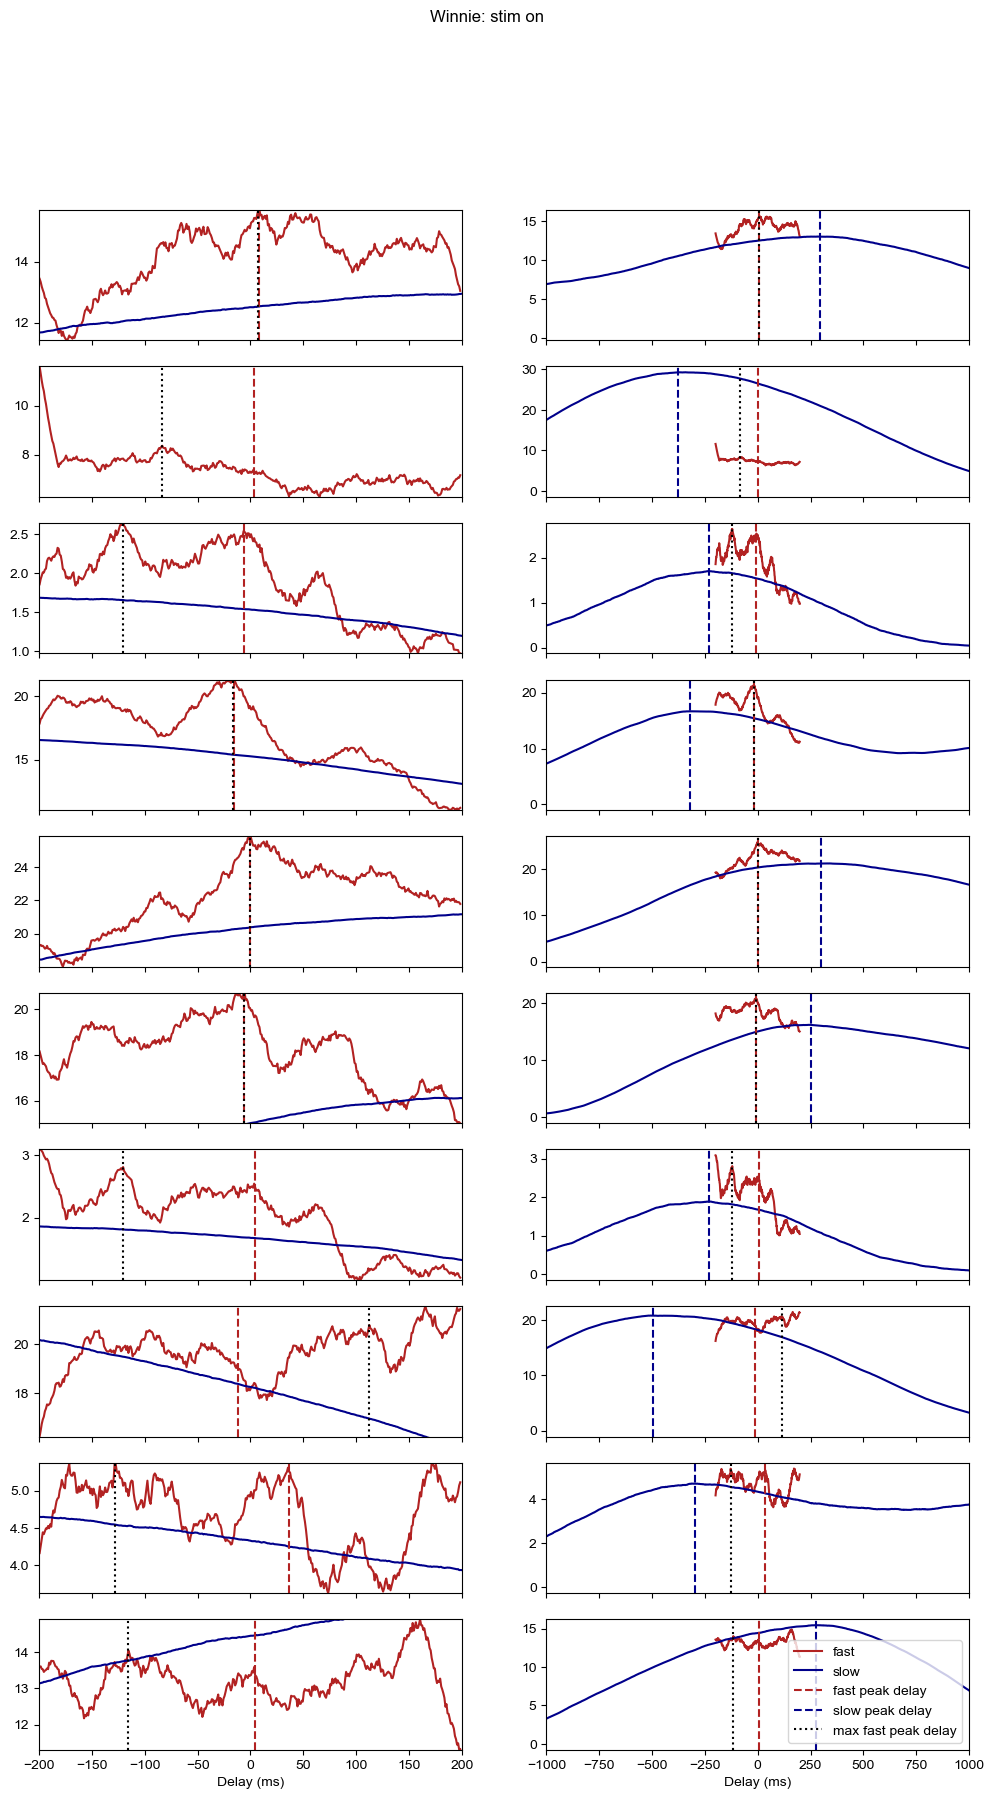

In [ ]:
animal = "Winnie"
df = results[animal]["test"]
# df = df[df.peak_delay_slow.abs() >400 ]
# df = df[df.peak_delay_slow.abs() < 1000]
df = df[df.peak_delay_slow.abs() > 200]
df = df[df.peak_delay_slow.abs() < 500]

slow_bins = np.arange(-3000, 2999) + 0.5
fast_bins = np.arange(-200, 199) + 0.5
fast_color = "firebrick"
slow_color = "darkblue"


fig, ax_array = plt.subplots(nrows=10, ncols=2, sharex="col", figsize=(12, 20))

from scipy.signal import find_peaks

# def get_max_fast_peak_delay(row):
#     fast_bins = np.arange(-200, 199) + 0.5
#     ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
#     # peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
#     # return fast_bins[ind_relevant][peak_ind]
#     peak_inds = find_peaks(row.cross_corr_fast[ind_relevant], distance=80)[0]
#     peak_values = row.cross_corr_fast[ind_relevant][peak_inds]
#     return fast_bins[ind_relevant][peak_inds[np.argmax(peak_values)]]


np.random.seed(1)
for j, pair_i in enumerate(np.random.choice(len(df), 10, replace=False)):
    ax = ax_array[j]
    row = df.iloc[pair_i]
    for i in range(2):
        ax[i].plot(fast_bins, row.cross_corr_fast, label="fast", color=fast_color)
        ax[i].plot(slow_bins, row.cross_corr_slow, label="slow", color=slow_color)
        ax[i].axvline(
            row.peak_delay_fast, ls="--", label="fast peak delay", color=fast_color
        )
        ax[i].axvline(
            row.peak_delay_slow, ls="--", label="slow peak delay", color=slow_color
        )
        ax[i].axvline(
            get_max_fast_peak_delay(row), ls=":", label="max fast peak delay", color="k"
        )
    ax[0].set_ylim(row.cross_corr_fast.min(), row.cross_corr_fast.max())

ax[0].set_xlim(-200, 200)
ax[1].set_xlim(-1000, 1000)
ax[1].set_xlim(-2000, 2000)
ax[0].set_xlabel("Delay (ms)")
ax[1].set_xlabel("Delay (ms)")
# plt.xlim(-500, 500)
plt.legend()
fig.suptitle(f"{animal}: stim on ")
plt.xlim(-1000, 1000)

# Fast-Fast consitency

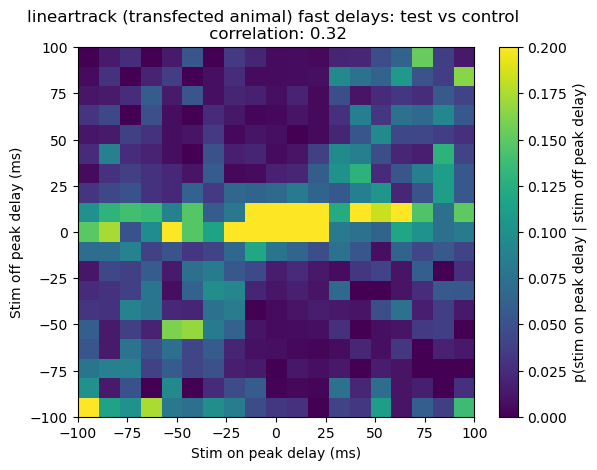

In [25]:
animal = "transfected"
# animal="control"

min_coincidients = 50
# test_delays = results[animal]["test"].peak_delay_fast
# control_delays = results[animal]["control"].peak_delay_fast

# plt.scatter(test_delays, control_delays, alpha=0.2)
fig = plt.figure()
merged_df = pd.merge(
    results[animal]["test"],
    results[animal]["control"],
    how="inner",
    on=["s_id_1", "s_id_2"],
)
merged_df = merged_df[
    np.logical_and(
        merged_df.n_coincidients_fast_x > min_coincidients,
        merged_df.n_coincidients_fast_y > min_coincidients,
    )
]

# test_delays = merged_df.peak_delay_fast_x
# control_delays = merged_df.peak_delay_fast_y

test_df = merged_df.copy()
test_df = test_df.rename(
    columns={
        "cross_corr_fast_x": "cross_corr_fast",
    }
)
test_delays = np.array([get_max_fast_peak_delay(row) for _, row in test_df.iterrows()])


control_df = merged_df.copy()
control_df = control_df.rename(
    columns={
        "cross_corr_fast_y": "cross_corr_fast",
    }
)
control_delays = np.array(
    [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
)

# plt.scatter(test_delays, control_delays, alpha=0.2)
H = np.histogram2d(
    control_delays,
    test_delays,
    bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
)[0]
H = H / H.sum(axis=1)[:, None]  #
# H = H/H.sum()

plt.imshow(
    H.T,
    origin="lower",
    extent=(-100, 100, -100, 100),
    # cmap="Blues",
    aspect="auto",
    clim=(0, 0.2),
)
plt.colorbar(label="p(stim on peak delay | stim off peak delay)")
# plt.clim(0.1)
#
np.corrcoef(test_delays, control_delays)[0, 1]

plt.title(
    f"{track} ({animal} animal) fast delays: test vs control \n correlation: {np.corrcoef(test_delays, control_delays)[0, 1]:.2f}"
)

plt.xlabel("Stim on peak delay (ms)")
plt.ylabel("Stim off peak delay (ms)")
# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_{animal}_fast_peak_delay_test_vs_control.svg"
# )
if animal == "control":
    fig.savefig(
        f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_control_fast_peak_delay_test_vs_control.svg"
    )
elif animal == "transfected":
    fig.savefig(
        f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_transfected_fast_peak_delay_test_vs_control.svg"
    )

# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_{animal}_fast_peak_delay_test_vs_control.svg"
# )

# plt.hist2d(
#     test_delays,
#     control_delays,
#     bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
#     cmap="Blues",
#     cmin=1,
# )

In [19]:
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [18]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        merged_df = pd.merge(
            results[animal]["test"],
            results[animal]["control"],
            how="inner",
            on=["s_id_1", "s_id_2"],
        )

        test_df = merged_df.copy()
        test_df = test_df.rename(
            columns={
                "cross_corr_fast_x": "cross_corr_fast",
            }
        )
        test_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
        )

        control_df = merged_df.copy()
        control_df = control_df.rename(
            columns={
                "cross_corr_fast_y": "cross_corr_fast",
            }
        )
        control_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
        )

        df = pd.DataFrame(
            {
                "control_delays": control_delays,
                "test_delays": test_delays,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} "):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        control_val = []
        test_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            control_val.extend(df.control_delays.values[pair_samples])
            test_val.extend(df.test_delays.values[pair_samples])
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted : 100%|██████████| 10000/10000 [00:10<00:00, 914.22it/s]


0.15253848

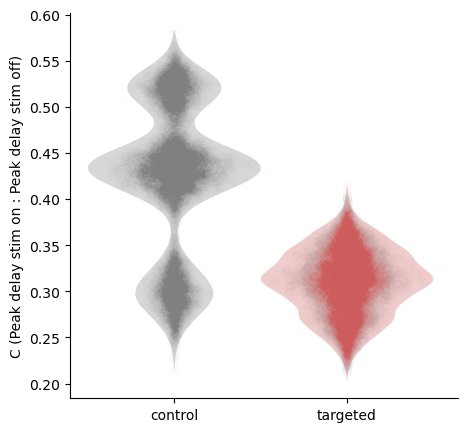

In [22]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )

test_diff_of_bootstrap_dist(bootstrap_results["control"], bootstrap_results["targeted"])

0.31672961027732827

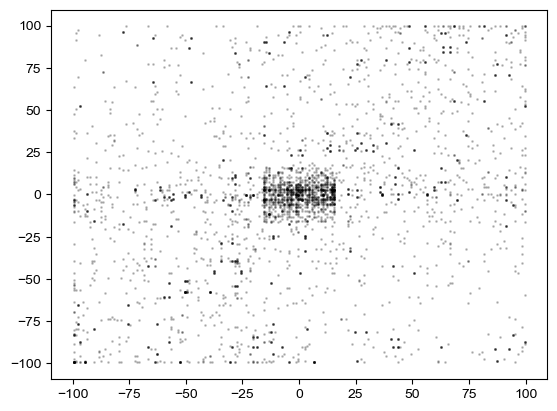

In [386]:
plt.scatter(
    control_delays,
    test_delays,
    alpha=0.2,
    s=1,
    color="k",
)
np.corrcoef(test_delays, control_delays)[0, 1]

### Non-heirarchical bootstrap

In [ ]:
from tqdm import tqdm

bootstrap_results = {}
n_boot = 10000


for animal in ["control", "transfected"]:
    df = results[animal]["test"]
    merged_df = pd.merge(
        results[animal]["test"],
        results[animal]["control"],
        how="inner",
        on=["s_id_1", "s_id_2"],
    )

    test_df = merged_df.copy()
    test_df = test_df.rename(
        columns={
            "cross_corr_fast_x": "cross_corr_fast",
        }
    )
    test_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
    )

    control_df = merged_df.copy()
    control_df = control_df.rename(
        columns={
            "cross_corr_fast_y": "cross_corr_fast",
        }
    )
    control_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
    )

    df = pd.DataFrame(
        {
            "control_delays": control_delays,
            "test_delays": test_delays,
        }
    )

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {animal} "):
        pair_samples = np.random.choice(len(df), len(df), replace=True)
        control_val = df.control_delays.values[pair_samples]
        test_val = df.test_delays.values[pair_samples]
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[animal] = c_

Bootstrapping transfected : 100%|██████████| 10000/10000 [00:02<00:00, 4536.74it/s]


0.00012743

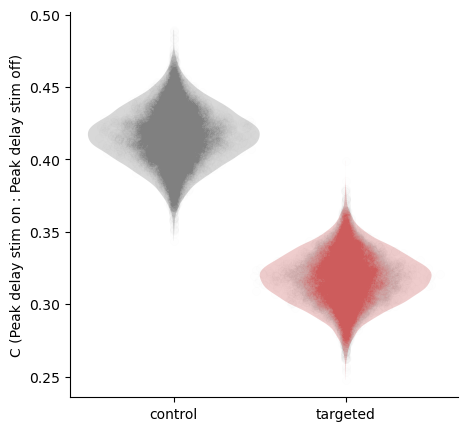

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_fast_fast_NonHierarchical_bootstrap_correlation_coefficients_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)

0.00012743

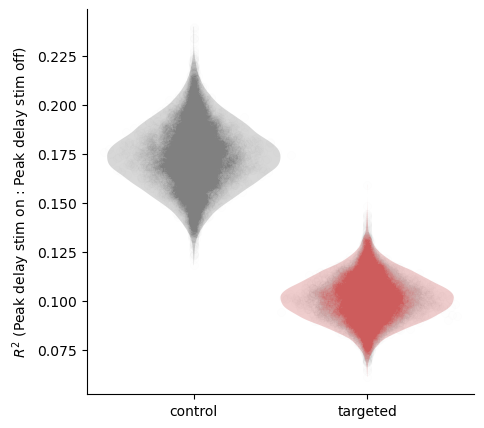

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal] ** 2
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("$R^2$ (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_fast_fast_NonHierarchical_bootstrap_R2_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)